## Quantization of TinyYolov2

In [10]:
import torch
import numpy as np

from models.my_tinyyolov2 import MyTinyYoloV2
from utils.dataloader import VOCDataLoaderPerson
from utils.ap import display_roc, ap
from utils.yolo import train, test, print_size_of_model
from utils.utils import identify_threshold
from utils.train import longtrain
import os
import time
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

loader = VOCDataLoaderPerson(train=True, batch_size=64, shuffle=True)
loader_test = VOCDataLoaderPerson(train=False, batch_size=1, shuffle=True)


In [ ]:
print('Size of pretrained model (MB):', os.path.getsize("models/configs/voc_pretrained.pt")/1e6)
print('Size of finetuned model (MB):', os.path.getsize("models/configs/voc_finetuned1.pt")/1e6)

In [ ]:
def net_time(model_class, testloader):
    
    #----to-be-done-by-student-------------------
    t_start = time.time()
    x, y = next(iter(testloader))
    model_class(x)
    t_end = time.time()
    #----to-be-done-by-student-------------------
    t = t_end - t_start
    return t

### Fuse Conv2d and BatchNorm2d weights and biases of TinyYolov2

In [6]:
def tensor_scale(input):
    return float(2*torch.max(torch.abs(torch.max(input)), torch.abs(torch.min(input))))/127.0

def fuse_conv_bn_weights(conv_w, bn_rm, bn_rv, bn_w, bn_b):
    """
    Input:
        conv_w: shape=(output_channels, in_channels, kernel_size, kernel_size)
        bn_rm:  shape=(output_channels)
        bn_rv:  shape=(output_channels)
        bn_w:   shape=(output_channels)
        bn_b:   shape=(output_channels)
    
    Output:
        fused_conv_w = shape=conv_w
        fused_conv_b = shape=conv_b
    """
    bn_eps = 1e-05

    
    fused_conv = torch.zeros(conv_w.shape)
    fused_bias = torch.zeros(bn_b.shape)
    
    #to-be-done-by-student
    #fused_conv = conv_w
    #fused_conv1 = bn_w / torch.sqrt(bn_rv * bn_rv + bn_eps)
    for i in range(len(fused_conv)):
        fused_conv[i] = conv_w[i] * bn_w[i] / torch.sqrt(bn_rv[i] + bn_eps)
    for i in range(len(fused_bias)):
        fused_bias[i] = (0 - bn_rm[i]) * bn_w[i] / torch.sqrt(bn_rv[i] + bn_eps) + bn_b[i]
    #fused_bias = (bn_w * (conv_b - bn_rm)) / torch.sqrt(bn_rv * bn_rv + bn_eps) + bn_b
    #to-be-done-by-student

    
    '''fused_conv_factor = torch.div(bn_w, torch.sqrt(torch.add(bn_rv, bn_eps)))
    fused_conv_factor = fused_conv_factor[:, None, None, None]
    fused_conv = conv_w * fused_conv_factor
    
    fused_bias_factor = torch.div(torch.mul(bn_w, bn_rm), torch.sqrt(torch.add(bn_rv, bn_eps)))
    fused_bias = torch.add(fused_bias_factor, bn_b)'''

    return fused_conv, fused_bias
    

In [7]:
def fuse(sd):
    net = MyTinyYoloV2(num_classes=1)
    qsd = net.state_dict()
    for layer in range(1,9):
        conv_w = sd[f"conv{layer}.weight"]
        bn_rm = sd[f"bn{layer}.running_mean"]
        bn_rv = sd[f"bn{layer}.running_var"]
        bn_w = sd[f"bn{layer}.weight"]
        bn_b = sd[f"bn{layer}.bias"]
        
        fused_weight, fused_bias = fuse_conv_bn_weights(conv_w, bn_rm, bn_rv, bn_w, bn_b)
            
        scale_fused_conv = tensor_scale(fused_weight)
        
        qsd[f"conv{layer}.weight"] = fused_weight
        qsd[f"conv{layer}.bias"] = fused_bias
    
    qsd["conv9.weight"] = sd["conv9.weight"]
    qsd["conv9.bias"] = sd["conv9.bias"]

    return qsd

In [8]:
net = MyTinyYoloV2(num_classes=1)
qsd = net.state_dict()
# load pretrained state
sd = torch.load("models/configs/voc_finetuned2.pt")

# fuse Conv and BatchNorm layers
print("------unquantized--------")
for key, value in sd.items():
    print(key, value.dtype)
print("------quantized--------")
for key, value in qsd.items():
    print(key, value.dtype)

for layer in range(1,9):
    conv_w = sd[f"conv{layer}.weight"]
    bn_rm = sd[f"bn{layer}.running_mean"]
    bn_rv = sd[f"bn{layer}.running_var"]
    bn_w = sd[f"bn{layer}.weight"]
    bn_b = sd[f"bn{layer}.bias"]
    
    fused_weight, fused_bias = fuse_conv_bn_weights(conv_w, bn_rm, bn_rv, bn_w, bn_b)
        
    scale_fused_conv = tensor_scale(fused_weight)
    
    qsd[f"conv{layer}.weight"] = fused_weight
    qsd[f"conv{layer}.bias"] = fused_bias

qsd["conv9.weight"] = sd["conv9.weight"]
qsd["conv9.bias"] = sd["conv9.bias"]
net.load_state_dict(qsd)

------unquantized--------
anchors torch.float32
conv1.weight torch.float32
bn1.weight torch.float32
bn1.bias torch.float32
bn1.running_mean torch.float32
bn1.running_var torch.float32
bn1.num_batches_tracked torch.int64
conv2.weight torch.float32
bn2.weight torch.float32
bn2.bias torch.float32
bn2.running_mean torch.float32
bn2.running_var torch.float32
bn2.num_batches_tracked torch.int64
conv3.weight torch.float32
bn3.weight torch.float32
bn3.bias torch.float32
bn3.running_mean torch.float32
bn3.running_var torch.float32
bn3.num_batches_tracked torch.int64
conv4.weight torch.float32
bn4.weight torch.float32
bn4.bias torch.float32
bn4.running_mean torch.float32
bn4.running_var torch.float32
bn4.num_batches_tracked torch.int64
conv5.weight torch.float32
bn5.weight torch.float32
bn5.bias torch.float32
bn5.running_mean torch.float32
bn5.running_var torch.float32
bn5.num_batches_tracked torch.int64
conv6.weight torch.float32
bn6.weight torch.float32
bn6.bias torch.float32
bn6.running_mean 

<All keys matched successfully>

In [ ]:
net.eval()
print("Size of model after fusion:")
print_size_of_model(net)

In [ ]:
# Test inference speedup
print(f"Time quantized: {net_time(net, loader_test)} s")

In [ ]:
dummy_input = next(iter(loader))
torch.onnx.export(net, dummy_input, "results/voc_fused.onnx", verbose=True)

In [ ]:
from utils.train import longtrain

sd = torch.load("results/voc_finetuned_123_frozen_layers_300_epochs_00003_lr_0001_decay.pt")
sd = fuse(sd)
sd = longtrain(MyTinyYoloV2, sd, device=device, epochs=300, frozen_layers=['1', '2', '3', '4', '5', '6', '7'], weight_decay=0.001, lr=0.00003, train_batch_size=256)

max_acc, max_nm, max_filter = identify_threshold(MyTinyYoloV2, sd, device=device)


print('Max accuracy:', max_accs)
print('With filter threshold:', max_filter)
print('With NMS threshold:', max_nms)

In [16]:
torch.save(sd, "results/voc_fused_7_frozen_layers_300_epochs_00003_lr_0001_decay.pt")

Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.42it/s]


average train losses 4.060749053955078
average test losses 3.2300924035558674
average precision 0.41885671904868393
test_precision 0.7983702384223432
test_recall 0.22691290191290192
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.61it/s]


average train losses 2.284498267703586
average test losses 2.7109255383157325
average precision 0.4284145833081965
test_precision 0.77070257240442
test_recall 0.27277485888597003
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.76it/s]


average train losses 1.8499890830781724
average test losses 2.2620355201582623
average precision 0.5027488112521286
test_precision 0.7796616961158603
test_recall 0.3183442072330961
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.41it/s]


average train losses 1.6185377173953586
average test losses 2.2940784295399985
average precision 0.46358163477433095
test_precision 0.7886098130028262
test_recall 0.30109530387308164
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 80.64it/s]


average train losses 1.495404839515686
average test losses 2.310656349118958
average precision 0.46158379377105097
test_precision 0.7730682228694314
test_recall 0.310590232812455
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.11s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.19it/s]


average train losses 0.9352446066008674
average test losses 1.7181007265407815
average precision 0.504741124191825
test_precision 0.779237746680215
test_recall 0.33609178886956664
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 80.06it/s]


average train losses 0.7920524411731296
average test losses 1.876441523644999
average precision 0.4750401235152895
test_precision 0.7908570551957902
test_recall 0.3273735523735524
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.40it/s]


average train losses 0.7460072173012627
average test losses 1.7250268204387096
average precision 0.4534663859838685
test_precision 0.7602324390612968
test_recall 0.32045988990433427
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.11s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.41it/s]


average train losses 0.715881367524465
average test losses 1.647923912778709
average precision 0.4709064784822361
test_precision 0.7703955519872567
test_recall 0.34356168522835184
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.11s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.03it/s]


average train losses 0.6823057863447402
average test losses 1.8260212312651496
average precision 0.46061451350541344
test_precision 0.7601828140362047
test_recall 0.3276885665774554
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.21it/s]


average train losses 0.6819840802086724
average test losses 1.7120472779046436
average precision 0.4286171174572153
test_precision 0.7508708919349258
test_recall 0.3066349288571511
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 81.23it/s]


average train losses 0.6542294422785441
average test losses 1.8321093791867593
average precision 0.4529032224176992
test_precision 0.7585981260507355
test_recall 0.3245735745735746
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.12s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 81.37it/s]


average train losses 0.6427398986286588
average test losses 1.8657576685023105
average precision 0.46578030303749035
test_precision 0.7758598327985888
test_recall 0.34082676582676585
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.12s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.88it/s]


average train losses 0.6283854146798452
average test losses 1.7599821713914898
average precision 0.4634574144092403
test_precision 0.7854132367878426
test_recall 0.320989195989196
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.12s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.22it/s]


average train losses 0.6315275364451938
average test losses 1.7532764639376406
average precision 0.43160800909936303
test_precision 0.7556073954191632
test_recall 0.3116568616568617
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.91it/s]


average train losses 0.6308405995368958
average test losses 1.8242290498014868
average precision 0.42494840477262535
test_precision 0.7431690348881832
test_recall 0.3123695234806346
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.12s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 80.37it/s]


average train losses 0.6088888314035203
average test losses 1.7681202089408694
average precision 0.5046757879302419
test_precision 0.769438176650168
test_recall 0.3641866364088586
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.12s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.61it/s]


average train losses 0.5747785634464688
average test losses 1.736384927377402
average precision 0.4692807185619929
test_precision 0.7652281257667701
test_recall 0.35006598339931677
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.34it/s]


average train losses 0.5585550963878632
average test losses 1.790104682395431
average precision 0.45319704392788174
test_precision 0.7665794529677705
test_recall 0.3327443132998688
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.08s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.29it/s]


average train losses 0.5695923931068845
average test losses 1.6199769939792121
average precision 0.5053627890396385
test_precision 0.7708693250917109
test_recall 0.34996012218234435
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.81it/s]


average train losses 0.5481168859534793
average test losses 1.7779032684798934
average precision 0.4287131247106824
test_precision 0.7504634679190705
test_recall 0.30978907923352367
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.40it/s]


average train losses 0.5776322649584876
average test losses 1.7310207054188789
average precision 0.45406145262057324
test_precision 0.7694458020149924
test_recall 0.3289928178817068
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.79it/s]


average train losses 0.5387854609224532
average test losses 1.9279871686359076
average precision 0.4420924788254167
test_precision 0.7758502345753772
test_recall 0.3044170849726405
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.73it/s]


average train losses 0.5581845740477244
average test losses 1.7447435810228018
average precision 0.5211133843709601
test_precision 0.7939879956585472
test_recall 0.36879016045682717
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.68it/s]


average train losses 0.5253786875141991
average test losses 1.7512055387736385
average precision 0.44341560372057653
test_precision 0.7751620124386248
test_recall 0.32762083595416924


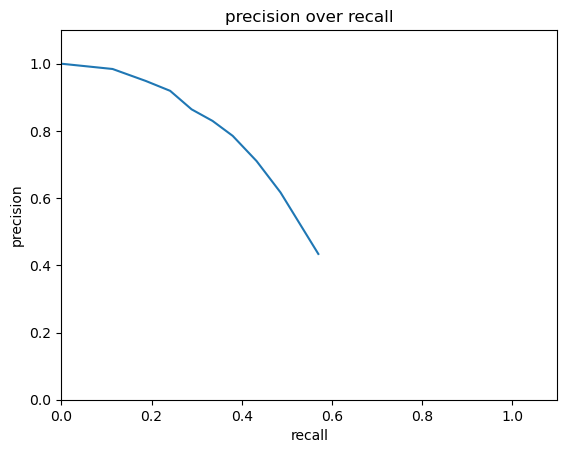

Epoch 26/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.24it/s]


average train losses 0.5149530304802789
average test losses 1.8372662017742794
average precision 0.46800578051549296
test_precision 0.7794372151479984
test_recall 0.33498260998261004
Epoch 27/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.09s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.03it/s]


average train losses 0.5014590819676717
average test losses 1.8510184958895557
average precision 0.4455993404772295
test_precision 0.7818279263816841
test_recall 0.3078165661498995
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.50it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.04it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.81it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 16.98it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:43<00:00,  9.68it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.66it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.09it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.56it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.89it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.77it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.38it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 196.48it/s]

Max accuracy: 0.515626454140535
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4,5
0,41.320000,48.220001,48.080002,51.560001,48.290001,47.900002
1,41.320000,48.220001,47.990002,47.939999,48.220001,47.840000
2,34.240002,41.919998,41.869999,41.689999,39.650002,39.470001
3,34.240002,34.540001,34.540001,34.279999,33.169998,33.060001
4,17.959999,26.580000,26.570000,26.530001,26.110001,26.070000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.66it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.12it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.02it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.61it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.02it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.75it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.12it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.48it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.47it/s]

Max accuracy: 0.5282445931984264
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,48.080002,52.820000,51.560001,50.639999,48.290001
1,47.990002,52.740002,51.500000,50.540001,48.220001
2,47.990002,48.459999,47.939999,50.540001,48.220001
3,41.869999,48.459999,47.939999,46.209999,44.529999
4,41.869999,41.720001,41.689999,40.730000,39.650002


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.61it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.71it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.31it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.58it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.90it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.31it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.54it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.57it/s]

Max accuracy: 0.5360773645976017
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,48.080002,53.110001,52.820000,52.240002,51.560001
1,50.950001,53.110001,52.740002,52.169998,53.610001
2,47.990002,53.110001,52.740002,52.169998,51.500000
3,47.990002,48.630001,48.459999,53.139999,52.439999
4,47.990002,48.630001,48.459999,48.169998,47.939999


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 73.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.31it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.49it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.85it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.94it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.95it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.66it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.58it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.82it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.49it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.80it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.39it/s]

Max accuracy: 0.5360773645976017
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,52.240002,51.720001,51.560001,50.790001,51.939999
1,53.299999,52.720001,52.509998,51.660000,52.689999
2,52.169998,51.650002,53.610001,52.619999,53.549999
3,52.169998,51.650002,51.500000,50.720001,51.820000
4,52.169998,51.650002,51.500000,50.720001,51.820000


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 101.04it/s]


average train losses 4.311535994211833
average test losses 3.2858587401544948
average precision 0.4337361639051615
test_precision 0.8217939321319274
test_recall 0.22247618636507527
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 81.44it/s]


average train losses 2.274007452858819
average test losses 2.637441677245659
average precision 0.49605538433012986
test_precision 0.7775777613036243
test_recall 0.30913952302841197
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.46it/s]


average train losses 1.8559311760796442
average test losses 2.4443528777853376
average precision 0.46104201634504655
test_precision 0.7751808234964632
test_recall 0.2977709533265089
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.82it/s]


average train losses 1.6252846982744005
average test losses 2.422173871104194
average precision 0.45192082177825904
test_precision 0.772843558893143
test_recall 0.3053017969684636
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 81.46it/s]


average train losses 1.4804538488388062
average test losses 2.422072022389143
average precision 0.4731647238400289
test_precision 0.7818195320892205
test_recall 0.31570456292678517
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.29it/s]


average train losses 0.9470538430743747
average test losses 1.7775574764210273
average precision 0.46087460339597097
test_precision 0.783732630468882
test_recall 0.3064169369724926
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.15it/s]


average train losses 0.8110947211583456
average test losses 1.7619701652784971
average precision 0.47163378830905495
test_precision 0.7814775634053973
test_recall 0.3181873681873682
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 76.39it/s]


average train losses 0.7457849648263719
average test losses 1.7721620134988063
average precision 0.464471117993331
test_precision 0.7585506709644771
test_recall 0.35101647323869545
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.18it/s]


average train losses 0.7011344565285577
average test losses 1.7045228690588237
average precision 0.4704896800370771
test_precision 0.7793586692801892
test_recall 0.33597914431247766
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.53it/s]


average train losses 0.6867317954699198
average test losses 1.6661435289472937
average precision 0.5243704706886612
test_precision 0.7864901105367479
test_recall 0.3649964233297567
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.63it/s]


average train losses 0.6670601566632589
average test losses 1.653199667095119
average precision 0.46961965434930375
test_precision 0.7723384759348866
test_recall 0.34606597106597103
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.14it/s]


average train losses 0.6572954720920987
average test losses 1.6820087310701524
average precision 0.5302998476562084
test_precision 0.800363113280963
test_recall 0.3531972143083254
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.72it/s]


average train losses 0.631573047902849
average test losses 1.7520892888817012
average precision 0.501185890591887
test_precision 0.7669870832893635
test_recall 0.35104093437426775
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.38it/s]


average train losses 0.6214724249309964
average test losses 1.758994262251589
average precision 0.4697610966258985
test_precision 0.7814073297984812
test_recall 0.333185847074736
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.53it/s]


average train losses 0.6134085191620721
average test losses 1.7545304873432868
average precision 0.45270760635951
test_precision 0.7671278997607898
test_recall 0.32982562704784923
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.66it/s]


average train losses 0.5828908350732591
average test losses 1.6223491617077777
average precision 0.46985026865562995
test_precision 0.7700302680888422
test_recall 0.35211845767401323
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.30it/s]


average train losses 0.5990446276134915
average test losses 1.6244588559679156
average precision 0.46124105541354954
test_precision 0.7605791775737842
test_recall 0.34032284587840145
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.00it/s]


average train losses 0.5890840027067397
average test losses 1.7244416723648708
average precision 0.4746605379569637
test_precision 0.7794058821593606
test_recall 0.34570820126375684
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.11it/s]


average train losses 0.5792667468388876
average test losses 1.6750635051319742
average precision 0.5005614953264527
test_precision 0.7623746645308417
test_recall 0.36435365046476154
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.42it/s]


average train losses 0.5709829065534804
average test losses 1.7352114243597387
average precision 0.4339891625645707
test_precision 0.761960942198394
test_recall 0.3136871359093581
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.29it/s]


average train losses 0.5571568012237549
average test losses 1.7377739783238482
average precision 0.40569512223681525
test_precision 0.7450247510730806
test_recall 0.2879997574442019
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.01it/s]


average train losses 0.587334500418769
average test losses 1.8129169946255168
average precision 0.4078248178636073
test_precision 0.7382583481023696
test_recall 0.2999146943591388
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.38it/s]


average train losses 0.5630681779649522
average test losses 1.6639072821605578
average precision 0.4354960192761281
test_precision 0.7702913904300237
test_recall 0.29853695687029025
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.29it/s]


average train losses 0.5356984701421525
average test losses 1.8855650948885925
average precision 0.42575927019038373
test_precision 0.7575665902905112
test_recall 0.2985307901974569
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.27it/s]


average train losses 0.5244630376497904
average test losses 1.840025854575583
average precision 0.4383454381609306
test_precision 0.7685843831143577
test_recall 0.3094916400471956
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.41it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.41it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:00<00:00,  8.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.90it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.12it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.25it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.38it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.83it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.89it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.22it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.91it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.92it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.92it/s]

Max accuracy: 0.5031001165494551
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4,5
0,41.380001,47.970001,48.259998,50.310001,46.770000,46.380001
1,41.380001,47.970001,48.169998,46.700001,44.509998,44.189999
2,34.240002,34.540001,41.950001,41.310001,39.320000,39.110001
3,26.430000,34.540001,34.560001,34.279999,33.320000,33.209999
4,18.020000,18.020000,18.020000,18.020000,17.950001,17.940001
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.20it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 13.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.05it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.90it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.78it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.17it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.21it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.43it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.74it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.63it/s]

Max accuracy: 0.5214737013311339
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,48.259998,52.150002,50.310001,48.799999,46.770000
1,48.169998,52.060001,50.250000,48.700001,46.700001
2,48.169998,47.770000,46.700001,46.049999,44.509998
3,41.950001,41.790001,41.310001,46.049999,44.509998
4,41.950001,41.790001,41.310001,40.320000,39.320000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.90it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.70it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.03it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.97it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.44it/s]

Max accuracy: 0.5251188001807351
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4500)


,0,1,2,3,4
0,48.259998,52.509998,52.150002,51.459999,50.310001
1,51.119999,52.509998,52.060001,51.389999,52.330002
2,48.169998,52.509998,52.060001,51.389999,50.250000
3,48.169998,48.020000,47.770000,52.360001,51.320000
4,48.169998,48.020000,47.770000,47.369999,46.700001


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.71it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.85it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.35it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.75it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.02it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.75it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.25it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.35it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.66it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.83it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.85it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.58it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.75it/s]

Max accuracy: 0.5270079455472073
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4250)


,0,1,2,3,4
0,48.259998,52.700001,52.509998,52.310001,52.150002
1,49.540001,52.700001,52.509998,52.310001,52.060001
2,51.119999,52.700001,52.509998,52.310001,52.060001
3,52.119999,52.700001,52.509998,52.310001,52.060001
4,48.169998,52.700001,52.509998,52.310001,52.060001


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.00it/s]


average train losses 4.234595616658528
average test losses 3.1367939995904255
average precision 0.4253247446394985
test_precision 0.8134358798431653
test_recall 0.21315484926596037
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 81.24it/s]


average train losses 2.2240520583258734
average test losses 2.544960292825672
average precision 0.48420729643505744
test_precision 0.7717327925936637
test_recall 0.3007766924433591
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 75.92it/s]


average train losses 1.8257171312967937
average test losses 2.477321129748624
average precision 0.4728569239406355
test_precision 0.775502238506896
test_recall 0.30516232738454957
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.00it/s]


average train losses 1.6167449156443279
average test losses 2.3868227546710914
average precision 0.42886268638867847
test_precision 0.7716238976505065
test_recall 0.2847285430618764
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.95it/s]


average train losses 1.4845277335908678
average test losses 2.0936675900407664
average precision 0.44779327020517207
test_precision 0.7683843006664578
test_recall 0.30307603918715026
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.82it/s]


average train losses 0.938344849480523
average test losses 1.5751098298024588
average precision 0.4748356107330466
test_precision 0.7999076892425919
test_recall 0.31740892852003966
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.05it/s]


average train losses 0.800192203786638
average test losses 1.6589634466884482
average precision 0.4854765306494134
test_precision 0.8036742832359254
test_recall 0.34308345975012644
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.80it/s]


average train losses 0.7360376318295797
average test losses 1.731837356510835
average precision 0.4751377014323218
test_precision 0.7881488476719064
test_recall 0.32266714766714766
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.68it/s]


average train losses 0.7135463290744357
average test losses 1.7039689437786059
average precision 0.430581262175064
test_precision 0.7583116650307371
test_recall 0.309762870873982
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.96it/s]


average train losses 0.6841090983814664
average test losses 1.7427100915132765
average precision 0.47114952286635176
test_precision 0.7820024166345215
test_recall 0.3377627516516405
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.16it/s]


average train losses 0.6640898651546903
average test losses 1.735984223202253
average precision 0.46157358102662543
test_precision 0.7685982665800014
test_recall 0.3359826387604165
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.60it/s]


average train losses 0.660914957523346
average test losses 1.6407715321712175
average precision 0.4997629873795375
test_precision 0.7810673743074675
test_recall 0.33598746932080265
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.58it/s]


average train losses 0.6491977572441101
average test losses 1.739063668741375
average precision 0.4654453731353955
test_precision 0.7730916939486834
test_recall 0.3438932466710245
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.02it/s]


average train losses 0.6313525239626566
average test losses 1.7178869778847592
average precision 0.46117420169993406
test_precision 0.7815647927198957
test_recall 0.32748856082189415
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.95it/s]


average train losses 0.6096899443202548
average test losses 1.7712623336461195
average precision 0.46548112022082494
test_precision 0.7783017264757744
test_recall 0.3324807908141241
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.46it/s]


average train losses 0.5994692246119181
average test losses 1.742031794195289
average precision 0.47142295601891565
test_precision 0.7908938971679379
test_recall 0.3364648725759837
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.03it/s]


average train losses 0.586096101337009
average test losses 1.5522676013898307
average precision 0.44282697391328957
test_precision 0.7691438672139344
test_recall 0.3321386432497544
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 78.59it/s]


average train losses 0.5697057578298781
average test losses 1.7166992078437084
average precision 0.4598068882110177
test_precision 0.7529644185656298
test_recall 0.35605166438499775
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.20it/s]


average train losses 0.5646131104893155
average test losses 1.6927376014002709
average precision 0.46169664460262755
test_precision 0.7633489995572358
test_recall 0.35470640470640474
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 79.28it/s]


average train losses 0.5521685944663154
average test losses 2.023806898427485
average precision 0.42708045879328843
test_precision 0.7481687750599721
test_recall 0.31114790559235006
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.57it/s]


average train losses 0.5536740356021457
average test losses 1.6131617560600624
average precision 0.5144132987696831
test_precision 0.784592754315624
test_recall 0.3605262021928689
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.55it/s]


average train losses 0.542772008313073
average test losses 1.8844128071179247
average precision 0.43686567610801585
test_precision 0.7688777792029222
test_recall 0.310896716452272
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.58it/s]


average train losses 0.5416866739590963
average test losses 1.9021355042982304
average precision 0.4324072690102902
test_precision 0.7486170365666687
test_recall 0.31909129964685523
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 100.43it/s]


average train losses 0.5367656217681037
average test losses 1.7598824268817221
average precision 0.44396645255231115
test_precision 0.7430429242977806
test_recall 0.3322917822917823
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.85it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.19it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.22it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.19it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.17it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.77it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.05it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.96it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.51it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.22it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.07it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.05it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.51it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.10it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 196.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 196.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 196.45it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 196.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.90it/s]

Max accuracy: 0.54271867575874
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,48.970001,49.459999,54.270000,52.590000,48.790001,48.590000
1,42.820000,49.459999,49.910000,52.520000,47.209999,47.029999
2,42.820000,42.720001,42.619999,41.450001,39.090000,38.990002
3,26.700001,26.690001,26.690001,26.600000,26.160000,26.139999
4,18.000000,18.000000,18.000000,17.990000,17.860001,17.850000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.88it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.83it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.16it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.49it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.75it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.56it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.03it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.31it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.24it/s]

Max accuracy: 0.5503177910362936
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,49.459999,50.230000,54.270000,55.029999,52.590000
1,49.459999,50.130001,54.270000,55.029999,52.520000
2,49.459999,50.130001,49.910000,55.029999,52.520000
3,42.720001,50.130001,49.910000,49.299999,47.730000
4,42.720001,42.709999,42.619999,42.330002,41.450001


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.13it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.66it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.51it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.51it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.85it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.19it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.99it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.88it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.05it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.37it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.97it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.65it/s]

Max accuracy: 0.5537737145522404
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.5500)


,0,1,2,3,4
0,54.270000,53.650002,55.029999,54.009998,52.590000
1,54.270000,53.650002,55.029999,55.380001,53.720001
2,54.270000,53.650002,55.029999,53.930000,52.520000
3,49.910000,54.900002,55.029999,53.930000,52.520000
4,49.910000,49.669998,55.029999,53.930000,52.520000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.25it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.90it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.03it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.85it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.09it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.68it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 73.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.45it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.87it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.72it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.13it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.00it/s]

Max accuracy: 0.5540020990101717
With filter threshold: tensor(0.0750)
With NMS threshold: tensor(0.5750)


,0,1,2,3,4
0,55.029999,54.480000,54.009998,53.380001,52.590000
1,55.029999,54.860001,54.369999,53.709999,52.910000
2,55.029999,54.400002,55.380001,54.619999,53.720001
3,55.029999,54.400002,53.930000,55.400002,54.450001
4,55.029999,54.400002,53.930000,53.299999,52.520000


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 102.98it/s]


average train losses 4.044829289118449
average test losses 3.3300274783729487
average precision 0.3744396976017859
test_precision 0.8141660206614423
test_recall 0.2023032523032523
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 80.27it/s]


average train losses 2.311071607801649
average test losses 2.7683657895126235
average precision 0.4257204977170607
test_precision 0.768496697538843
test_recall 0.27784345284345285
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.54it/s]


average train losses 1.8415130641725328
average test losses 2.5019400946774715
average precision 0.45518302778403785
test_precision 0.7753863316959282
test_recall 0.2806299667410779
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.37it/s]


average train losses 1.6081835826237996
average test losses 2.413214078995577
average precision 0.4541984260749227
test_precision 0.7655040133816984
test_recall 0.310139654584099
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.09it/s]


average train losses 1.4943086703618367
average test losses 2.21696845673428
average precision 0.4374647652600837
test_precision 0.7817264811593869
test_recall 0.2882970938526494
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.23it/s]


average train losses 0.9461888273557028
average test losses 1.6035050555341943
average precision 0.4703183147479047
test_precision 0.7816285736695678
test_recall 0.32094808483697373
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.06it/s]


average train losses 0.8055207398202684
average test losses 1.6816410392183185
average precision 0.46882179896371584
test_precision 0.7702822119020047
test_recall 0.3244235188679633
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.69it/s]


average train losses 0.7517521248923408
average test losses 1.7247451078518163
average precision 0.4658798020880383
test_precision 0.7670474332350136
test_recall 0.3231515398182065
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.58it/s]


average train losses 0.7329698999722799
average test losses 1.607499628367587
average precision 0.47456429294036134
test_precision 0.779929157561819
test_recall 0.34808339808339805
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.50it/s]


average train losses 0.7025963001781039
average test losses 1.7256042203332624
average precision 0.5122371852635985
test_precision 0.784093866257804
test_recall 0.35494320494320497
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.40it/s]


average train losses 0.6944634781943427
average test losses 1.702829809609981
average precision 0.46512337269913023
test_precision 0.7811020462742735
test_recall 0.32878017044683705
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.71it/s]


average train losses 0.6840364535649618
average test losses 1.772905217064412
average precision 0.4694397655353366
test_precision 0.7828856130972917
test_recall 0.33961707017262577
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.05it/s]


average train losses 0.6721626851293776
average test losses 1.5599187434441344
average precision 0.5268021254577635
test_precision 0.7790591432492576
test_recall 0.3801010717677384
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.85it/s]


average train losses 0.6619824369748434
average test losses 1.7373059427742434
average precision 0.47900774870471835
test_precision 0.7766125863260007
test_recall 0.3481256397923065
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.33it/s]


average train losses 0.6582934260368347
average test losses 1.7027980864812167
average precision 0.4713565011350559
test_precision 0.7793077329013615
test_recall 0.3500610500610501
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.30it/s]


average train losses 0.6558960742420621
average test losses 1.7757783495526538
average precision 0.4661013092637024
test_precision 0.7735056547273742
test_recall 0.3379018101240323
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.99it/s]


average train losses 0.6839333905114068
average test losses 1.6735357748095128
average precision 0.5092593419127995
test_precision 0.7789023553786568
test_recall 0.35311046977713645
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.27it/s]


average train losses 0.656018939283159
average test losses 1.7583920282770766
average precision 0.4446993109483397
test_precision 0.7492044772413564
test_recall 0.3274536163425052
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.86it/s]


average train losses 0.6683622201283773
average test losses 1.7847786672901564
average precision 0.4707706312372888
test_precision 0.770240059421767
test_recall 0.3299558466225133
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.06s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.31it/s]


average train losses 0.6478453410996331
average test losses 1.7349663637260087
average precision 0.46109856616392564
test_precision 0.7549127822677802
test_recall 0.33904983904983904
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.43it/s]


average train losses 0.7343240976333618
average test losses 1.6289285359177155
average precision 0.46173855612015496
test_precision 0.776815321284755
test_recall 0.3093476482365372
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.76it/s]


average train losses 0.6620178487565782
average test losses 1.7175407973449794
average precision 0.47591556045324507
test_precision 0.7851223471819765
test_recall 0.33847777736666623
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.93it/s]


average train losses 0.6531319816907247
average test losses 1.7098683911213848
average precision 0.4768347339442911
test_precision 0.7881203643434168
test_recall 0.340900046455602
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.05it/s]


average train losses 0.6365140941407945
average test losses 1.7796194078533398
average precision 0.4747892025669804
test_precision 0.7761689108037204
test_recall 0.3450255505811061
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.60it/s]


average train losses 0.6416917774412367
average test losses 1.788160899086216
average precision 0.4425704147975083
test_precision 0.7685719161923814
test_recall 0.3282514810292588
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.41it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.42it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.70it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.19it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.64it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.73it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 142.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.39it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.31it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.56it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.94it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.13it/s]


Max accuracy: 0.5374716885251587
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4,5
0,48.980000,48.610001,53.720001,53.750000,49.529999,48.790001
1,48.980000,48.610001,49.169998,53.680000,47.709999,47.049999
2,42.270000,42.200001,42.160000,41.990002,39.549999,39.169998
3,34.599998,34.580002,34.570000,34.290001,32.910000,32.669998
4,17.920000,17.910000,17.910000,17.879999,17.629999,17.580000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.03it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.10it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.43it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.89it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.13it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.92it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.56it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.87it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.13it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.49it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.24it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.45it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.40it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.38it/s]

Max accuracy: 0.5374716885251587
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,53.720001,53.009998,53.750000,52.779999,49.529999
1,53.720001,52.930000,53.680000,52.720001,49.490002
2,49.169998,48.790001,53.680000,50.400002,47.709999
3,49.169998,48.790001,48.369999,46.270000,44.279999
4,42.160000,41.980000,41.990002,40.860001,39.549999


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.14it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.80it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.03it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.87it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.03it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.55it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.38it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.81it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.19it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.16it/s]

Max accuracy: 0.5608385873653361
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.5500)


,0,1,2,3,4
0,53.009998,54.099998,53.750000,52.279999,52.779999
1,52.930000,56.080002,55.480000,53.650002,52.720001
2,52.930000,54.020000,53.680000,52.160000,52.720001
3,53.990002,54.020000,53.680000,52.160000,50.400002
4,48.790001,54.020000,53.680000,52.160000,50.400002


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.85it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.45it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.60it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.43it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.18it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.02it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.36it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.12it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.21it/s]

Max accuracy: 0.5635118691612186
With filter threshold: tensor(0.0750)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,53.009998,54.520000,54.099998,53.720001,53.750000
1,53.910000,55.380001,54.910000,54.480000,54.459999
2,52.930000,54.439999,56.080002,55.560001,55.480000
3,52.930000,54.439999,54.020000,53.650002,56.349998
4,52.930000,54.439999,54.020000,53.650002,53.680000


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.95it/s]


average train losses 3.9999775091807046
average test losses 3.0986231986613695
average precision 0.4110313164005073
test_precision 0.7926058755664794
test_recall 0.23676231176231174
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.00it/s]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.24it/s]


average train losses 2.1791171497768826
average test losses 2.5878184716246406
average precision 0.46416353337030697
test_precision 0.7847937623095107
test_recall 0.27994186883075767
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.82it/s]


average train losses 1.7659739123450384
average test losses 2.400148815069443
average precision 0.46379507821986915
test_precision 0.7874487202738759
test_recall 0.3061673922785034
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.80it/s]


average train losses 1.5615575181113348
average test losses 2.233935824401698
average precision 0.4697817949749025
test_precision 0.7950030826742093
test_recall 0.29927284649506875
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.00it/s]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.39it/s]


average train losses 1.453428586324056
average test losses 2.2364066504684947
average precision 0.43981609620980594
test_precision 0.7887791341423114
test_recall 0.28184541795652907
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.74it/s]


average train losses 0.9035803609424167
average test losses 1.6723979109118128
average precision 0.467862122912628
test_precision 0.7824509626841912
test_recall 0.32227052782608334
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.24it/s]


average train losses 0.7825830843713548
average test losses 1.6538583688395485
average precision 0.4699053372850164
test_precision 0.7800480571779368
test_recall 0.33004392726614945
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.97it/s]


average train losses 0.737181994650099
average test losses 1.6932150789050975
average precision 0.4753798109858716
test_precision 0.786896151862361
test_recall 0.3477175088286199
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.47it/s]


average train losses 0.6998779508802626
average test losses 1.671636321711914
average precision 0.4688954696918955
test_precision 0.7762601884849606
test_recall 0.34007268451712896
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.25it/s]


average train losses 0.7068521777788798
average test losses 1.7784208111953193
average precision 0.4674771471585768
test_precision 0.7867327443866667
test_recall 0.33020210242432463
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.32it/s]


average train losses 0.6617117590374417
average test losses 1.7218440414706186
average precision 0.46144652061512975
test_precision 0.7752140065754899
test_recall 0.3355256883034661
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.95it/s]


average train losses 0.7049064503775703
average test losses 1.6821742886067117
average precision 0.5160654410406035
test_precision 0.7837303664198476
test_recall 0.36986079763857543
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.74it/s]


average train losses 0.6504719191127353
average test losses 1.7338324728769454
average precision 0.46140478704581267
test_precision 0.7764011347713335
test_recall 0.3208087180309403
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.94it/s]


average train losses 0.6471532517009311
average test losses 1.7842103765476123
average precision 0.43947845784350237
test_precision 0.7748224494967582
test_recall 0.32463781074892184
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.32it/s]


average train losses 0.6330961916181777
average test losses 1.7383902278381196
average precision 0.5075851150757754
test_precision 0.7749156156596241
test_recall 0.3486303819637153
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.58it/s]


average train losses 0.6068989435831705
average test losses 1.7787475784619649
average precision 0.44075277543443375
test_precision 0.7737192567577869
test_recall 0.3231604814938148
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.77it/s]


average train losses 0.6057240433163114
average test losses 1.6142506596029993
average precision 0.46008877953322397
test_precision 0.7578046253557018
test_recall 0.34416879416879415
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.87it/s]


average train losses 0.6045294337802463
average test losses 1.656084325387437
average precision 0.46966233355122244
test_precision 0.7648094768335638
test_recall 0.3514089819645375
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.49it/s]


average train losses 0.5916355318493314
average test losses 1.9595505096591437
average precision 0.4342311265308203
test_precision 0.7638942175689742
test_recall 0.31268464046241823
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.88it/s]


average train losses 0.5828922920756869
average test losses 1.841275357113265
average precision 0.4335657033403731
test_precision 0.7645104386121968
test_recall 0.3136316358538581
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.62it/s]


average train losses 0.56238853931427
average test losses 1.7876508042980463
average precision 0.4526017296899193
test_precision 0.7540739343097222
test_recall 0.3328996106773885
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.28it/s]


average train losses 0.5448990331755744
average test losses 1.759077549362794
average precision 0.4318684050631712
test_precision 0.7560979462131973
test_recall 0.3204280287613621
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.76it/s]


average train losses 0.5237710740831163
average test losses 1.805081305574318
average precision 0.4529018694908361
test_precision 0.7762342080306796
test_recall 0.33713580658025105
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.80it/s]


average train losses 0.5150979624854194
average test losses 1.8195677601819873
average precision 0.47366722747453127
test_precision 0.7841434993020989
test_recall 0.3357929107929108
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.65it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.61it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.90it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.71it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.35it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.02it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.22it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.07it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.93it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.51it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 166.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.23it/s]


Max accuracy: 0.5402896896542434
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,47.599998,49.110001,54.029999,52.480000,48.570000,48.360001
1,42.529999,49.110001,49.619999,52.410000,46.959999,46.770000
2,42.529999,42.470001,42.380001,41.240002,38.820000,38.720001
3,26.620001,26.610001,26.620001,26.530001,26.070000,26.049999
4,17.980000,17.980000,17.980000,17.959999,17.830000,17.830000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.64it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.10it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.61it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.47it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.38it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.18it/s]


Max accuracy: 0.5402896896542434
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4
0,49.110001,49.099998,54.029999,52.709999,52.480000
1,49.110001,49.009998,54.029999,52.709999,52.410000
2,49.110001,49.009998,49.619999,49.009998,52.410000
3,42.470001,42.459999,49.619999,49.009998,47.540001
4,42.470001,42.459999,42.380001,42.080002,41.240002


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.65it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.98it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.78it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.45it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.61it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.94it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.33it/s]

Max accuracy: 0.54723563583339
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.4500)


,0,1,2,3,4
0,49.099998,48.990002,54.029999,53.509998,52.709999
1,49.009998,51.470001,54.029999,53.509998,52.709999
2,49.009998,48.889999,54.029999,53.509998,52.709999
3,49.009998,48.889999,49.619999,54.720001,53.910000
4,49.009998,48.889999,49.619999,49.400002,49.009998


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.13it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.75it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.56it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.24it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.30it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.91it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.19it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.19it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.93it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.88it/s]

Max accuracy: 0.55011967486831
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.4250)


,0,1,2,3,4
0,54.029999,53.820000,53.509998,53.169998,52.709999
1,54.700001,54.500000,54.209999,53.840000,53.349998
2,49.619999,55.009998,54.720001,54.380001,53.910000
3,49.619999,49.529999,49.400002,54.939999,54.490002
4,49.619999,49.529999,49.400002,49.250000,49.009998


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 104.88it/s]


average train losses 4.106346713172065
average test losses 3.2783673047340156
average precision 0.42868188307333244
test_precision 0.8157192995021981
test_recall 0.23179968179968183
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.05it/s]


average train losses 2.335930003060235
average test losses 2.631623591452922
average precision 0.43817869572020385
test_precision 0.747407224525574
test_recall 0.28412431190208964
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.00it/s]


average train losses 1.8234025769763522
average test losses 2.4067194715694145
average precision 0.48694132279990865
test_precision 0.8141648239232958
test_recall 0.30193284082172966
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.05it/s]


average train losses 1.6154786215888128
average test losses 2.3458042604121725
average precision 0.4641403317393994
test_precision 0.7795543265075653
test_recall 0.30616605616605613
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.68it/s]


average train losses 1.485088547070821
average test losses 2.283858448861331
average precision 0.46668858638555605
test_precision 0.7726450912469809
test_recall 0.3155555349999795
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.14it/s]


average train losses 0.9243043396208022
average test losses 1.8259359010604033
average precision 0.46868703902503434
test_precision 0.7767850320491968
test_recall 0.31473547029102583
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.13it/s]


average train losses 0.7847674820158217
average test losses 1.8056432421390827
average precision 0.47093046274281697
test_precision 0.7796620179584437
test_recall 0.33254656865767973
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.03it/s]


average train losses 0.7265608310699463
average test losses 1.7192976501507637
average precision 0.4441862994466483
test_precision 0.7646350835668145
test_recall 0.31972759750537527
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.94it/s]


average train losses 0.7026660574807061
average test losses 1.7891745816948068
average precision 0.4633955787801941
test_precision 0.76189984615595
test_recall 0.34138741916519694
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.78it/s]


average train losses 0.6863730152448019
average test losses 1.7429808985516217
average precision 0.4683974555186676
test_precision 0.7792931617626054
test_recall 0.3348984348984349
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.69it/s]


average train losses 0.6675713459650675
average test losses 1.7248715085436477
average precision 0.46115114776730937
test_precision 0.7596525679276263
test_recall 0.349715716382383
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.20it/s]


average train losses 0.6448816061019897
average test losses 1.726851792247207
average precision 0.4823128690067307
test_precision 0.789746329148267
test_recall 0.36116650838873066
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.53it/s]


average train losses 0.6340633100933499
average test losses 1.7109948651721845
average precision 0.4668789430684699
test_precision 0.7767181084730937
test_recall 0.3434719601386268
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.04it/s]


average train losses 0.619479238986969
average test losses 1.8775017694318057
average precision 0.4611839280434617
test_precision 0.7530502341015215
test_recall 0.3396330007441119
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.41it/s]


average train losses 0.6140063073900011
average test losses 1.721772479662868
average precision 0.5033193437122804
test_precision 0.7596205658450353
test_recall 0.3652719708275264
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.74it/s]


average train losses 0.5879137582249112
average test losses 1.7859876746593037
average precision 0.45924480495187564
test_precision 0.7764521460794805
test_recall 0.3248590915257582
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 100.55it/s]


average train losses 0.5978697803285387
average test losses 1.624602186543989
average precision 0.5143601740642642
test_precision 0.7902010801220811
test_recall 0.359380742714076
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.84it/s]


average train losses 0.5757919351259867
average test losses 1.6239283337467416
average precision 0.43238673679273987
test_precision 0.7654997096361137
test_recall 0.2995030689475134
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.38it/s]


average train losses 0.5753978888193766
average test losses 1.5815601254736427
average precision 0.47468150069160164
test_precision 0.7830826173555683
test_recall 0.3469334163778608
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.15it/s]


average train losses 0.54513990216785
average test losses 1.9497955019487614
average precision 0.4365912389313824
test_precision 0.761977096076575
test_recall 0.31286563231007675
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 101.56it/s]


average train losses 0.5438894761933221
average test losses 1.7709722500029113
average precision 0.4354189736934186
test_precision 0.7603011871026021
test_recall 0.32553598664709776
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.64it/s]


average train losses 0.5263907776938545
average test losses 1.8516931617871308
average precision 0.4594324680183266
test_precision 0.7512593352142692
test_recall 0.34917602973158524
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.79it/s]


average train losses 0.5324080255296495
average test losses 1.7712528172381583
average precision 0.46881639972160566
test_precision 0.7812890387996654
test_recall 0.3504685643574532
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.30it/s]


average train losses 0.5120398435327742
average test losses 1.7760275672388892
average precision 0.4695956395005712
test_precision 0.7705469037361632
test_recall 0.34054237943126836
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.82it/s]


average train losses 0.5216124223338233
average test losses 1.6874232850544304
average precision 0.5115515701436291
test_precision 0.7799889873246204
test_recall 0.347979797979798


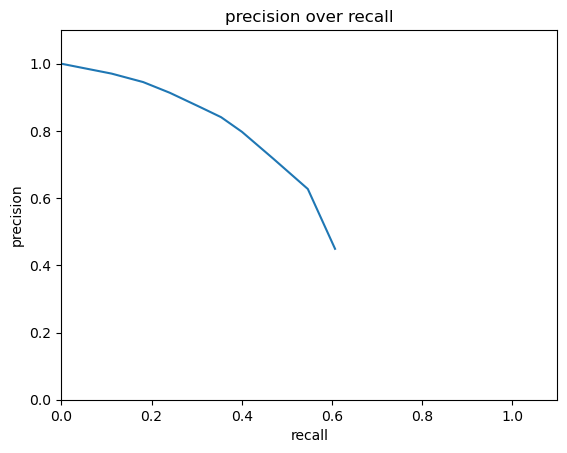

Epoch 26/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.79it/s]


average train losses 0.5212115943431854
average test losses 1.852431358138041
average precision 0.4267484432888473
test_precision 0.7465595284165603
test_recall 0.31001817112928226
Epoch 27/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.06it/s]


average train losses 0.5180344780286154
average test losses 1.696603255871779
average precision 0.4619059018048917
test_precision 0.7838388923562521
test_recall 0.3320983543205765
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.16it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:00<00:00,  8.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.82it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.25it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.13it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.82it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.90it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.49it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.45it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.89it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.83it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.92it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.03it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.91it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.22it/s]

Max accuracy: 0.5329174897054386
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,45.270000,48.759998,53.290001,52.180000,48.990002,48.549999
1,41.770000,48.759998,48.570000,48.570000,48.919998,48.490002
2,34.560001,42.320000,42.310001,42.169998,40.200001,39.990002
3,34.560001,34.810001,34.799999,34.580002,33.570000,33.450001
4,18.020000,26.719999,26.719999,26.650000,26.320000,26.270000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.54it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.99it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.22it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.45it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.64it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.66it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.40it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.40it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.90it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.80it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.45it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.50it/s]

Max accuracy: 0.5337951672847692
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,48.759998,48.790001,53.290001,53.380001,52.180000
1,48.759998,48.700001,53.290001,53.299999,52.119999
2,48.759998,48.700001,48.570000,48.959999,48.570000
3,42.320000,42.330002,42.310001,48.959999,48.570000
4,42.320000,42.330002,42.310001,42.119999,42.169998


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.36it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.68it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.80it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.74it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.54it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.97it/s]

Max accuracy: 0.5422033594805076
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,53.290001,52.990002,53.380001,52.700001,52.180000
1,53.290001,52.990002,53.299999,52.619999,54.220001
2,53.290001,52.990002,53.299999,52.619999,52.119999
3,48.570000,48.410000,48.959999,53.680000,53.180000
4,48.570000,48.410000,48.959999,48.619999,48.570000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.60it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.65it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.62it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 73.54it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.62it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.16it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.95it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.28it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.51it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.41it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.79it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.83it/s]

Max accuracy: 0.5490658139854072
With filter threshold: tensor(0.0750)
With NMS threshold: tensor(0.6500)


,0,1,2,3,4
0,52.700001,52.299999,52.180000,51.490002,52.560001
1,53.709999,53.270000,53.080002,52.320000,53.340000
2,52.619999,54.509998,54.220001,53.330002,54.250000
3,52.619999,52.230000,52.119999,51.419998,54.910000
4,52.619999,52.230000,52.119999,51.419998,52.500000


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.96it/s]


average train losses 4.03307663069831
average test losses 3.2099213046565693
average precision 0.4237814270296068
test_precision 0.8113272235928137
test_recall 0.23279806613139947
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.77it/s]


average train losses 2.151199393802219
average test losses 2.8533705571438173
average precision 0.4779845848106356
test_precision 0.7676201238964314
test_recall 0.29185218074106967
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.87it/s]


average train losses 1.7464411126242743
average test losses 2.4205510500829104
average precision 0.4671177969403437
test_precision 0.7812257531823097
test_recall 0.3019304769304769
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.55it/s]


average train losses 1.5660663180881076
average test losses 2.470443428072155
average precision 0.43933539193089516
test_precision 0.7908843922039077
test_recall 0.2825744214633104
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.10it/s]


average train losses 1.4538396861818101
average test losses 2.2236059813248126
average precision 0.4624777390373636
test_precision 0.7770350490615336
test_recall 0.316501194278972
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.87it/s]


average train losses 0.9171208010779487
average test losses 1.750622142350402
average precision 0.5123603635928909
test_precision 0.7919408992673208
test_recall 0.3392161336605781
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 101.46it/s]


average train losses 0.7906153400739034
average test losses 1.6004354842113293
average precision 0.5057382209154457
test_precision 0.7802404967060573
test_recall 0.34607182940516273
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.82it/s]


average train losses 0.7348814474211799
average test losses 1.5515334042176563
average precision 0.47426769178905936
test_precision 0.7790657430685193
test_recall 0.32807059195948085
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.45it/s]


average train losses 0.6859696838590834
average test losses 1.640808031812013
average precision 0.47937212935270423
test_precision 0.7934636272835002
test_recall 0.35976975699197916
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.41it/s]


average train losses 0.6756708688206143
average test losses 1.7632846725929496
average precision 0.5161408155802664
test_precision 0.7731353216211523
test_recall 0.36225585114473996
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.14it/s]


average train losses 0.6523233983251784
average test losses 1.662455390321563
average precision 0.46655512104230046
test_precision 0.7669150817118346
test_recall 0.344106613551058
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.61it/s]


average train losses 0.641000145011478
average test losses 1.6964384148857872
average precision 0.4788145104772921
test_precision 0.7859238573382272
test_recall 0.35350493128270905
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.18it/s]


average train losses 0.6345094045003256
average test losses 1.9078980038138875
average precision 0.4656540335833265
test_precision 0.7554029836932692
test_recall 0.35771553549331325
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 80.97it/s]


average train losses 0.6187398301230537
average test losses 1.8549038018511232
average precision 0.46716966161410606
test_precision 0.7735341706905403
test_recall 0.3498399748399748
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.73it/s]


average train losses 0.6115232639842563
average test losses 1.563045480482259
average precision 0.46533206426368817
test_precision 0.7721357910978445
test_recall 0.3359090497979387
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.41it/s]


average train losses 0.6080587638749017
average test losses 1.7877435775054487
average precision 0.4525215367095709
test_precision 0.7493708413780172
test_recall 0.33326190270634715
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 100.13it/s]


average train losses 0.6137669616275363
average test losses 1.6775765427497038
average precision 0.47616316530457947
test_precision 0.7915228751270161
test_recall 0.3506052589385923
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.59it/s]


average train losses 0.6280207501517402
average test losses 1.7263947536165898
average precision 0.46543871967337386
test_precision 0.7726392701600243
test_recall 0.32995677162343834
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.03it/s]


average train losses 0.61092476050059
average test losses 1.7547669376106003
average precision 0.4467395240670984
test_precision 0.7496912999235582
test_recall 0.3150617900617901
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.34it/s]


average train losses 0.5709270768695407
average test losses 1.6277389596203113
average precision 0.5026526543117794
test_precision 0.7682131175343845
test_recall 0.35313667813667815
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.14it/s]


average train losses 0.5636737181080712
average test losses 1.7608208958367337
average precision 0.4785348748635462
test_precision 0.7875519192546936
test_recall 0.34045224323002105
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.17it/s]


average train losses 0.5708386169539558
average test losses 1.8341997890730528
average precision 0.43933949318053517
test_precision 0.7702096031442124
test_recall 0.3206537289870623
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.93it/s]


average train losses 0.5291845202445984
average test losses 1.804090848134199
average precision 0.4631615973884816
test_precision 0.7689500051319605
test_recall 0.347254186143075
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.18it/s]


average train losses 0.5342810087733798
average test losses 1.7337804342649261
average precision 0.4643756844611545
test_precision 0.7656432403500367
test_recall 0.33168272057160947
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.80it/s]


average train losses 0.5122610992855496
average test losses 1.7265796148327002
average precision 0.46691295984225273
test_precision 0.776151164137361
test_recall 0.33892784170561946
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.35it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.12it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.34it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.89it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.78it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.61it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.13it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.60it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.83it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.75it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.27it/s]

Max accuracy: 0.5370635569213419
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,46.250000,48.419998,53.709999,53.000000,49.369999,48.860001
1,42.320000,48.419998,49.340000,52.930000,47.580002,47.130001
2,42.320000,42.180000,42.520000,41.900002,39.750000,39.490002
3,34.799999,34.770000,34.759998,34.480000,33.380001,33.220001
4,26.730000,26.730000,26.730000,26.650000,26.280001,26.230000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.34it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.60it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.50it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.21it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.40it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.60it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.13it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.89it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.67it/s]

Max accuracy: 0.5370635569213419
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4
0,48.419998,49.189999,53.709999,53.070000,53.000000
1,48.419998,49.090000,53.709999,52.980000,52.930000
2,48.419998,49.090000,49.340000,49.049999,52.930000
3,42.180000,49.090000,49.340000,49.049999,47.990002
4,42.180000,42.189999,42.520000,42.410000,41.900002


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.59it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.42it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.09it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.35it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.26it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.18it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.65it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.49it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.30it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 111.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.04it/s]


Max accuracy: 0.5410938967529014
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,49.189999,49.130001,53.709999,53.410000,53.070000
1,49.090000,51.740002,53.709999,53.410000,52.980000
2,49.090000,49.029999,53.709999,53.410000,52.980000
3,49.090000,49.029999,49.340000,49.250000,54.110001
4,49.090000,49.029999,49.340000,49.250000,49.049999


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.74it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.26it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.59it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.87it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.65it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.87it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.83it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.48it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.18it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.33it/s]

Max accuracy: 0.544570306204844
With filter threshold: tensor(0.1750)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,53.410000,53.180000,52.980000,54.430000,53.959999
1,54.020000,53.820000,53.610001,54.430000,53.959999
2,49.250000,54.310001,54.110001,54.430000,53.959999
3,49.250000,49.150002,54.459999,54.430000,53.959999
4,49.250000,49.150002,49.049999,54.430000,53.959999


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.21it/s]


average train losses 4.481152349048191
average test losses 3.503703443413107
average precision 0.4278635616680369
test_precision 0.8138172842040124
test_recall 0.2377093071537516
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.52it/s]


average train losses 2.389165931277805
average test losses 2.59065496327191
average precision 0.4838492384661716
test_precision 0.7698753340799606
test_recall 0.29740136406803075
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.69it/s]


average train losses 1.8872726360956829
average test losses 2.5321020139248622
average precision 0.46347637196053476
test_precision 0.7830548609128996
test_recall 0.2904388821055488
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.21it/s]


average train losses 1.6087968349456787
average test losses 2.409505212918306
average precision 0.4656067153616173
test_precision 0.7722963536195584
test_recall 0.31860320749209636
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.38it/s]


average train losses 1.515107684665256
average test losses 2.1813882412733854
average precision 0.4734208532341686
test_precision 0.7949655163192948
test_recall 0.30439683773017107
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.05it/s]


average train losses 0.9502110878626505
average test losses 1.6632800332119322
average precision 0.4846040812047028
test_precision 0.8029007516729738
test_recall 0.33885558885558886
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.22it/s]


average train losses 0.8246225648456149
average test losses 1.6325915791200436
average precision 0.527215286396615
test_precision 0.7977125735344383
test_recall 0.35504218004218
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.50it/s]


average train losses 0.7613646189371744
average test losses 1.648165844274722
average precision 0.5251855879878143
test_precision 0.7860582118957651
test_recall 0.3499705027482805
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.44it/s]


average train losses 0.7361710998747084
average test losses 1.6772076443601878
average precision 0.4734971257698531
test_precision 0.7736195589152072
test_recall 0.33087416698527805
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.81it/s]


average train losses 0.7238247858153449
average test losses 1.6019837819676623
average precision 0.5141699409898368
test_precision 0.7849785121088653
test_recall 0.3541415374748708
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.81it/s]


average train losses 0.6971321635776095
average test losses 1.6744726753854684
average precision 0.47068561211460797
test_precision 0.7709768607692035
test_recall 0.34618467951801285
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.39it/s]


average train losses 0.6923333870040046
average test losses 1.6502624173194935
average precision 0.47562516622345685
test_precision 0.7905289246547967
test_recall 0.34343372676706013
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.16it/s]


average train losses 0.6801028384102715
average test losses 1.656469503104517
average precision 0.4708970135737813
test_precision 0.7680563643976048
test_recall 0.3444020999576555
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.34it/s]


average train losses 0.6725696060392592
average test losses 1.8378096412007625
average precision 0.47089128173044253
test_precision 0.7750669360536502
test_recall 0.3447703531036864
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.25it/s]


average train losses 0.6570996973249648
average test losses 1.8052868896782228
average precision 0.4668546880816637
test_precision 0.7702190352584186
test_recall 0.3497572386461275
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.10it/s]


average train losses 0.6805153224203322
average test losses 1.7188920172998028
average precision 0.470449840671286
test_precision 0.7729202122485669
test_recall 0.3543454487898932
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.83it/s]


average train losses 0.6756644712554084
average test losses 1.7277568305532138
average precision 0.4679145482564286
test_precision 0.772861723275362
test_recall 0.3483414733414733
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.71it/s]


average train losses 0.6796557241015964
average test losses 1.6141671134196116
average precision 0.5250977986429458
test_precision 0.7790436208988724
test_recall 0.3753815114926226
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.35it/s]


average train losses 0.6431455612182617
average test losses 1.7714855019268487
average precision 0.5015507785521268
test_precision 0.7656689107555236
test_recall 0.3510447371558482
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.10it/s]


average train losses 0.6374566091431512
average test losses 1.7187115162653461
average precision 0.4785210983151931
test_precision 0.7645425270929495
test_recall 0.3609831526498193
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.38it/s]


average train losses 0.630739669005076
average test losses 1.8007767340990892
average precision 0.4335923815567538
test_precision 0.7581331503482881
test_recall 0.3224849224849224
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.60it/s]


average train losses 0.625313487317827
average test losses 1.706570140401862
average precision 0.5010201203009615
test_precision 0.7665058621771019
test_recall 0.3573397795620018
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.16it/s]


average train losses 0.6206896702448527
average test losses 1.5806049615717852
average precision 0.527248956072257
test_precision 0.7854392398030133
test_recall 0.3768034434701101
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.93it/s]


average train losses 0.603498101234436
average test losses 1.7867547868833242
average precision 0.47152095760293117
test_precision 0.7638806225950767
test_recall 0.3556768334546112
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.20it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.78it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.24it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.08it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.61it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.13it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.55it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.45it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.49it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.24it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.96it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.74it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.80it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.93it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.38it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.74it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.34it/s]

Max accuracy: 0.5402029299054925
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,41.930000,49.180000,54.020000,52.779999,48.930000,48.759998
1,41.930000,49.180000,49.720001,52.709999,47.380001,47.230000
2,34.509998,42.560001,42.490002,41.450001,39.119999,39.049999
3,26.379999,26.620001,26.629999,26.540001,26.160000,26.139999
4,17.959999,17.959999,17.959999,17.940001,17.860001,17.850000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.07it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.75it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.21it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.62it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.24it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.75it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.17it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.08it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.48it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.85it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.66it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.66it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.44it/s]

Max accuracy: 0.5402029299054925
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4
0,49.180000,49.230000,54.020000,52.709999,52.779999
1,49.180000,49.130001,54.020000,52.709999,52.709999
2,49.180000,49.130001,49.720001,49.150002,52.709999
3,42.560001,42.560001,49.720001,49.150002,47.790001
4,42.560001,42.560001,42.490002,42.209999,41.450001


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 27.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.41it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.07it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.30it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.81it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.04it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.19it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.51it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.30it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.75it/s]

Max accuracy: 0.5484003816810822
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.4500)


,0,1,2,3,4
0,49.230000,49.099998,54.020000,53.549999,52.709999
1,49.130001,51.290001,54.020000,53.549999,52.709999
2,49.130001,49.009998,54.020000,53.549999,52.709999
3,49.130001,49.009998,49.720001,54.840000,54.040001
4,49.130001,49.009998,49.720001,49.529999,49.150002


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.89it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.49it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.90it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.59it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.49it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.30it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.10it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.62it/s]

Max accuracy: 0.5508426304103713
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.4250)


,0,1,2,3,4
0,54.020000,53.799999,53.549999,53.160000,52.709999
1,54.730000,54.540001,54.279999,53.889999,53.430000
2,49.720001,55.080002,54.840000,54.480000,54.040001
3,49.720001,49.639999,49.529999,54.939999,54.509998
4,49.720001,49.639999,49.529999,49.380001,49.150002


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.05it/s]


average train losses 4.343909899393718
average test losses 3.6186872058444552
average precision 0.41478518059776187
test_precision 0.7967270998968942
test_recall 0.21991434491434494
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.07it/s]


average train losses 2.2423843012915716
average test losses 2.8416560327904854
average precision 0.43362624340698824
test_precision 0.7731119281726407
test_recall 0.281981906981907
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.18it/s]


average train losses 1.806722362836202
average test losses 2.4450935684038364
average precision 0.44136012550054926
test_precision 0.7940251419189205
test_recall 0.2825926131481687
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.24it/s]


average train losses 1.6166237327787611
average test losses 2.484997504966551
average precision 0.43774479810962963
test_precision 0.7904774519548938
test_recall 0.2911365383587606
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.72it/s]


average train losses 1.4503094487720065
average test losses 2.572434689584281
average precision 0.466769876205865
test_precision 0.7841346556178407
test_recall 0.3092110564332786
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.53it/s]


average train losses 0.9086311062177023
average test losses 1.5968035198854245
average precision 0.5252754597515654
test_precision 0.8054667488750598
test_recall 0.34365665198998535
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.59it/s]


average train losses 0.7966499725977579
average test losses 1.7491795896125315
average precision 0.43340216006909493
test_precision 0.7668089768605251
test_recall 0.3047491603047159
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.73it/s]


average train losses 0.7455214858055115
average test losses 1.728971377545782
average precision 0.4675015682868983
test_precision 0.7728152636939475
test_recall 0.340089334533779
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.36it/s]


average train losses 0.7024091415935092
average test losses 1.7005305325883067
average precision 0.46992354623933574
test_precision 0.7702517831641869
test_recall 0.33990361490361487
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.23it/s]


average train losses 0.6860226922565036
average test losses 1.7857575025780927
average precision 0.4620798192282264
test_precision 0.7633768244233218
test_recall 0.32922992645214866
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.86it/s]


average train losses 0.6775100098715888
average test losses 1.7980937063906268
average precision 0.49307670548319876
test_precision 0.7589975784184081
test_recall 0.34310812644145977
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.60it/s]


average train losses 0.6558917164802551
average test losses 1.7057723438744021
average precision 0.4781001315315041
test_precision 0.7894393798923885
test_recall 0.3400411317077984
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.42it/s]


average train losses 0.6588826974232992
average test losses 1.685855905023905
average precision 0.47808053913337517
test_precision 0.7940207763388079
test_recall 0.33045627212293877
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.27it/s]


average train losses 0.6310605539215935
average test losses 1.7904143119363534
average precision 0.4631159525098919
test_precision 0.7689189953224753
test_recall 0.3447598697598698
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.40it/s]


average train losses 0.6221869389216105
average test losses 1.5897237278860687
average precision 0.46867312304375247
test_precision 0.7726474452171119
test_recall 0.34068883791106014
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.49it/s]


average train losses 0.6084285709593031
average test losses 1.8659268766641617
average precision 0.46680479654450124
test_precision 0.7715633039377148
test_recall 0.3357576579798802
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.27it/s]


average train losses 0.6006060573789809
average test losses 1.7445568344913995
average precision 0.4573704533688994
test_precision 0.7690840815907269
test_recall 0.3349542432875766
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.91it/s]


average train losses 0.5923213097784255
average test losses 1.684875223350491
average precision 0.4622936137504902
test_precision 0.7710053361328557
test_recall 0.3324037074037074
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.86it/s]


average train losses 0.5885822905434502
average test losses 1.6943095195242481
average precision 0.4407907572728863
test_precision 0.7717083126951036
test_recall 0.33245447967670183
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.75it/s]


average train losses 0.5887070364422269
average test losses 1.8068338414797416
average precision 0.43624623379970373
test_precision 0.7673660283820591
test_recall 0.31432908655130876
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.76it/s]


average train losses 0.5819431013531156
average test losses 1.7795981972603037
average precision 0.46223410176401636
test_precision 0.7626351165859966
test_recall 0.34849307071529295
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.05it/s]


average train losses 0.5750343998273214
average test losses 1.6205232082905932
average precision 0.4689152889327714
test_precision 0.7731622689496994
test_recall 0.3321573488240155
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.10it/s]


average train losses 0.5755018790562948
average test losses 1.7876509440972594
average precision 0.4310229267992598
test_precision 0.774602563629977
test_recall 0.29693454693454696
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.00it/s]


average train losses 0.5585640139049954
average test losses 1.7546770650882837
average precision 0.46447021926819915
test_precision 0.7880216701025643
test_recall 0.3260887260887261
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.28it/s]


average train losses 0.5853378242916532
average test losses 1.599142288624646
average precision 0.45381963043076434
test_precision 0.7909397239599716
test_recall 0.32803205025427246
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.87it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.88it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.22it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.99it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.60it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.31it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.51it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.39it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.03it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.74it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.64it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.07it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.61it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.94it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.31it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.38it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.96it/s]


Max accuracy: 0.5341874373135034
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4,5
0,42.000000,48.099998,53.070000,53.419998,49.790001,49.259998
1,42.000000,48.099998,48.660000,53.349998,47.930000,47.470001
2,42.000000,41.860001,41.849998,42.060001,39.980000,39.730000
3,34.549999,34.509998,34.520000,34.549999,33.490002,33.349998
4,18.020000,18.020000,18.030001,26.650000,26.309999,26.250000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.49it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.80it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.20it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.43it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.81it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.36it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.94it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.61it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.66it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.47it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.37it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.17it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.54it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.85it/s]

Max accuracy: 0.5341874373135034
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,53.070000,52.630001,53.419998,52.490002,49.790001
1,53.070000,52.540001,53.349998,52.439999,49.759998
2,48.660000,48.549999,53.349998,50.160000,47.930000
3,48.660000,48.549999,48.200001,46.139999,44.540001
4,41.849998,41.950001,42.060001,40.930000,39.980000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.60it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.72it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.79it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.07it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.73it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.19it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.28it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.07it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.74it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.66it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.98it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.50it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.06it/s]

Max accuracy: 0.5508481835844319
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,52.630001,52.540001,53.419998,52.040001,52.490002
1,52.540001,52.459999,55.080002,53.380001,52.439999
2,52.540001,52.459999,53.349998,51.919998,52.439999
3,53.599998,53.529999,53.349998,51.919998,50.160000
4,48.549999,48.779999,53.349998,51.919998,50.160000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.54it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.14it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.26it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.98it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.54it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 73.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.19it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.95it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.79it/s]

Max accuracy: 0.5508481835844319
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,52.540001,52.110001,53.419998,52.770000,52.040001
1,53.270000,52.799999,54.070000,53.389999,52.560001
2,52.459999,53.889999,55.080002,54.310001,53.380001
3,52.459999,52.040001,53.349998,55.070000,54.060001
4,52.459999,52.040001,53.349998,52.700001,51.919998


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.00it/s]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.94it/s]


average train losses 4.138593408796522
average test losses 3.425478356855887
average precision 0.42059142920604037
test_precision 0.8054011353148954
test_recall 0.23267586323141878
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.22it/s]


average train losses 2.268785039583842
average test losses 2.854632674459039
average precision 0.45790319877850705
test_precision 0.7806693927963261
test_recall 0.28887079998191106
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.01it/s]


average train losses 1.8385063939624362
average test losses 2.5550495139893643
average precision 0.46290405578478616
test_precision 0.7862585371424355
test_recall 0.2909005603450047
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.59it/s]


average train losses 1.623743560579088
average test losses 2.317566661073951
average precision 0.4624525895699167
test_precision 0.7752000413831989
test_recall 0.31110227221338327
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.75it/s]


average train losses 1.487159424357944
average test losses 2.2736313101912495
average precision 0.46870613486775103
test_precision 0.7900892315480879
test_recall 0.31717017550350884
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.86it/s]


average train losses 0.9081881973478529
average test losses 1.8466052590654447
average precision 0.4432117270546214
test_precision 0.7848199021171903
test_recall 0.2976433031988588
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.43it/s]


average train losses 0.7968870600064596
average test losses 1.7358183881368732
average precision 0.5171119002190463
test_precision 0.7794006196324148
test_recall 0.3474492585603697
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.16it/s]


average train losses 0.7278650138113234
average test losses 1.7441195560316753
average precision 0.4493795197943902
test_precision 0.7921646307947738
test_recall 0.3148107036995926
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.46it/s]


average train losses 0.7062728007634481
average test losses 1.7714793944885248
average precision 0.473249022249205
test_precision 0.7757262095513653
test_recall 0.3408659241992575
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.56it/s]


average train losses 0.6899988783730401
average test losses 1.7839248587517997
average precision 0.475469658216813
test_precision 0.7791099177150197
test_recall 0.34493140604251715
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.18it/s]


average train losses 0.6733223133616977
average test losses 1.7144581301514579
average precision 0.4775423129346983
test_precision 0.7792839356368796
test_recall 0.35568998902332233
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.54it/s]


average train losses 0.6566411852836609
average test losses 1.5701312654123687
average precision 0.5089764206934618
test_precision 0.7796469858784995
test_recall 0.3526159026159026
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.17it/s]


average train losses 0.6374276611540053
average test losses 1.9069802459233847
average precision 0.42995106524587007
test_precision 0.751234378059419
test_recall 0.31470484248262026
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.75it/s]


average train losses 0.6236754854520162
average test losses 1.845967379390684
average precision 0.4623691059005745
test_precision 0.7573528408929936
test_recall 0.3344152760819427
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.69it/s]


average train losses 0.6179608835114373
average test losses 1.7189035556701004
average precision 0.4791459173515026
test_precision 0.787886502448792
test_recall 0.34814290647623986
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.80it/s]


average train losses 0.6050391859478421
average test losses 1.769364526638618
average precision 0.5176859596868065
test_precision 0.7715423994446371
test_recall 0.3666032527143638
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.85it/s]


average train losses 0.5999359687169393
average test losses 1.7018672280395641
average precision 0.4735531677450869
test_precision 0.7736316983136525
test_recall 0.3589517478406367
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.44it/s]


average train losses 0.61491549677319
average test losses 1.7453395843166233
average precision 0.4591486472605354
test_precision 0.7634244129264467
test_recall 0.3259008481230704
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.64it/s]


average train losses 0.6133620076709323
average test losses 1.717297223462933
average precision 0.4357622286022807
test_precision 0.7648306811828911
test_recall 0.31756494534272306
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 102.17it/s]


average train losses 0.62044890721639
average test losses 1.6732782209530854
average precision 0.43416648863412277
test_precision 0.7595124861245222
test_recall 0.30946358168580385
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.99it/s]


average train losses 0.5863924225171407
average test losses 1.8070011373259063
average precision 0.4463448188709855
test_precision 0.7819625751432506
test_recall 0.3288363899475011
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 102.19it/s]


average train losses 0.5674954023626115
average test losses 1.6571293215498202
average precision 0.48389926571744757
test_precision 0.8024259633428242
test_recall 0.33911736411736415
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.26it/s]


average train losses 0.5618993639945984
average test losses 1.6445160445059381
average precision 0.4734566823144912
test_precision 0.7833564614850322
test_recall 0.34541374263596486
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.91it/s]


average train losses 0.5430746343400743
average test losses 1.8266210301734105
average precision 0.43996097457018624
test_precision 0.765903511925034
test_recall 0.32382216548883214
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.82it/s]


average train losses 0.5315057436625162
average test losses 1.75086455196779
average precision 0.5108076594966512
test_precision 0.7806607861512709
test_recall 0.3585735252401919


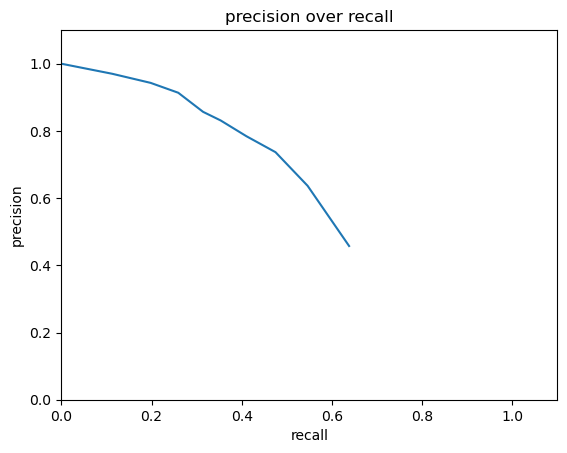

Epoch 26/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 100.73it/s]


average train losses 0.5310356650087569
average test losses 1.5850952032242405
average precision 0.4778611306389084
test_precision 0.7913425686521091
test_recall 0.3374518485629597
Epoch 27/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.77it/s]


average train losses 0.5227190454800924
average test losses 1.6903694299954464
average precision 0.4435343296111913
test_precision 0.7607537563923283
test_recall 0.3239248405915072
Epoch 28/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.55it/s]


average train losses 0.5128955278131697
average test losses 1.7701381371911096
average precision 0.4329439557915073
test_precision 0.7549528589812953
test_recall 0.3176623787734899
Epoch 29/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.53it/s]


average train losses 0.5221652620368533
average test losses 1.7595424916160072
average precision 0.43939106664436894
test_precision 0.7666051429648943
test_recall 0.3348351237240126
Epoch 30/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.34it/s]


average train losses 0.4978971547550625
average test losses 1.7145185274233845
average precision 0.4418238359671926
test_precision 0.7761979042282073
test_recall 0.3182138848805516
Epoch 31/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.58it/s]


average train losses 0.4954451455010308
average test losses 1.8075832052957639
average precision 0.44178781781197335
test_precision 0.7726151350329786
test_recall 0.321977096977097
Epoch 32/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.28it/s]


average train losses 0.5059412254227532
average test losses 1.819415232097661
average precision 0.43317643046781296
test_precision 0.7568485403978944
test_recall 0.31549952105507667
Epoch 33/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.84it/s]


average train losses 0.49995461106300354
average test losses 1.747601496676604
average precision 0.43617638768265865
test_precision 0.7655618526001725
test_recall 0.30990840435284883
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.66it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.91it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.16it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.75it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.22it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.07it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.17it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.98it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.30it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.37it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.13it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.59it/s]

Max accuracy: 0.5376686891138605
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4,5
0,46.310001,48.750000,53.740002,53.770000,49.799999,49.270000
1,42.439999,48.750000,49.230000,53.700001,47.980000,47.509998
2,42.439999,42.330002,42.279999,42.150002,39.950001,39.720001
3,34.900002,34.869999,34.860001,34.599998,33.480000,33.340000
4,26.750000,26.740000,26.740000,26.680000,26.330000,26.270000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.49it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.61it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.50it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.80it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.72it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.47it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.60it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.49it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.54it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.93it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.05it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.24it/s]

Max accuracy: 0.5376686891138605
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4
0,53.740002,53.439999,53.770000,52.590000,49.799999
1,53.740002,53.360001,53.700001,52.529999,49.770000
2,49.230000,49.279999,53.700001,50.299999,47.980000
3,49.230000,49.279999,48.450001,46.240002,44.580002
4,42.279999,42.520000,42.150002,40.900002,39.950001


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.03it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.75it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.94it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.55it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.04it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.70it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.50it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.74it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.96it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.82it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.58it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.93it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.34it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.38it/s]

Max accuracy: 0.567381186641611
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.5500)


,0,1,2,3,4
0,53.439999,54.740002,53.770000,55.020000,52.590000
1,53.360001,56.740002,55.480000,54.950001,52.529999
2,53.360001,54.669998,53.700001,54.950001,52.529999
3,54.509998,54.669998,53.700001,52.189999,50.299999
4,49.279999,54.669998,53.700001,52.189999,50.299999


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.14it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.36it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.95it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.72it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.28it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.87it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.96it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.99it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.71it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.94it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.59it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.34it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.32it/s]

Max accuracy: 0.567381186641611
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.5500)


,0,1,2,3,4
0,53.439999,53.130001,54.740002,54.180000,53.770000
1,53.360001,53.930000,55.500000,54.880001,54.419998
2,53.360001,53.049999,56.740002,56.020000,55.480000
3,53.360001,53.049999,54.669998,54.110001,53.700001
4,53.360001,53.049999,54.669998,54.110001,53.700001


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.14it/s]


average train losses 4.116002957026164
average test losses 3.312106795800038
average precision 0.4242604446266872
test_precision 0.8109488577710864
test_recall 0.23563350230016897
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.24it/s]


average train losses 2.2820466094546847
average test losses 2.7562347006933643
average precision 0.4280835194415809
test_precision 0.7674569835064396
test_recall 0.2860852110852111
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.77it/s]


average train losses 1.8362461858325534
average test losses 2.4245164745044163
average precision 0.4913654046229748
test_precision 0.7739936637760925
test_recall 0.3136602081046525
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.61it/s]


average train losses 1.583419640858968
average test losses 2.462476011015411
average precision 0.42171441646120156
test_precision 0.7599915350911659
test_recall 0.2759956093289426
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.52it/s]


average train losses 1.4557253784603543
average test losses 2.3867945762780995
average precision 0.4645351403898413
test_precision 0.7706191169053094
test_recall 0.3186901575790465
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.56it/s]


average train losses 0.9204993579122756
average test losses 1.8196787106515335
average precision 0.42727714780041415
test_precision 0.7700408054332744
test_recall 0.28894459450015003
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.42it/s]


average train losses 0.7836956779162089
average test losses 1.6873821274847047
average precision 0.4836986152642719
test_precision 0.8030023396686735
test_recall 0.32478509145175816
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.60it/s]


average train losses 0.7277784479988946
average test losses 1.7871627424262528
average precision 0.4627881542765678
test_precision 0.7675307375465166
test_recall 0.32093965705076816
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.60it/s]


average train losses 0.7047574387656318
average test losses 1.7889381088422573
average precision 0.4804419299368794
test_precision 0.7817892939595467
test_recall 0.33950833117499785
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.61it/s]


average train losses 0.6884653700722588
average test losses 1.552353569436447
average precision 0.49100344962815823
test_precision 0.7924788304269224
test_recall 0.35804319137652474
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.82it/s]


average train losses 0.6758445236417983
average test losses 1.9009544493741968
average precision 0.47021210241192873
test_precision 0.7790621919436985
test_recall 0.3384452995564107
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.89it/s]


average train losses 0.658009303940667
average test losses 1.6405203556721537
average precision 0.5123922363708893
test_precision 0.7922499729384366
test_recall 0.3480733258511036
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.96it/s]


average train losses 0.6423096458117167
average test losses 1.7763159888931828
average precision 0.467990909769556
test_precision 0.7738158949899137
test_recall 0.3364892309336754
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.58it/s]


average train losses 0.637085907989078
average test losses 1.6722770035054608
average precision 0.5086150228620875
test_precision 0.7800541277401761
test_recall 0.35219564386231056
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.46it/s]


average train losses 0.6263372633192275
average test losses 1.6528179393895501
average precision 0.48293647990617683
test_precision 0.7922073099423526
test_recall 0.35866160588382806
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.41it/s]


average train losses 0.6147076752450731
average test losses 1.5770252215917464
average precision 0.4808339183047808
test_precision 0.794532156237673
test_recall 0.3539019622352955
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 103.14it/s]


average train losses 0.6009815202818977
average test losses 1.671430151538122
average precision 0.454489386696069
test_precision 0.7588777682439065
test_recall 0.32768301657190546
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.65it/s]


average train losses 0.6011106040742662
average test losses 1.7127226671771785
average precision 0.4763331599190185
test_precision 0.787650056910535
test_recall 0.3465129520685076
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.99it/s]


average train losses 0.6074379218949212
average test losses 1.8575038034097422
average precision 0.454071407967729
test_precision 0.7788284700321456
test_recall 0.32890473723807057
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.15it/s]


average train losses 0.6222922205924988
average test losses 1.8086655808777212
average precision 0.43197982571925614
test_precision 0.7531957204142861
test_recall 0.31711405878072546
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 100.44it/s]


average train losses 0.6082460681597391
average test losses 1.7068658453595436
average precision 0.4498121952754609
test_precision 0.7806668049266695
test_recall 0.32400511011622124
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 103.24it/s]


average train losses 0.6553308235274421
average test losses 1.6248010498633412
average precision 0.5191154593630327
test_precision 0.7974538046777783
test_recall 0.35046589213255885
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.52it/s]


average train losses 0.5846643911467658
average test losses 1.754912862994647
average precision 0.45691056255981527
test_precision 0.7887714244254762
test_recall 0.33565580510024956
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.45it/s]


average train losses 0.5595205823580424
average test losses 1.7570568705216432
average precision 0.4377115824514014
test_precision 0.7608703625294878
test_recall 0.31429249762583095
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.59it/s]


average train losses 0.5619814727041457
average test losses 1.7282909490486495
average precision 0.4276142255875486
test_precision 0.7507114375804652
test_recall 0.32639839584284025


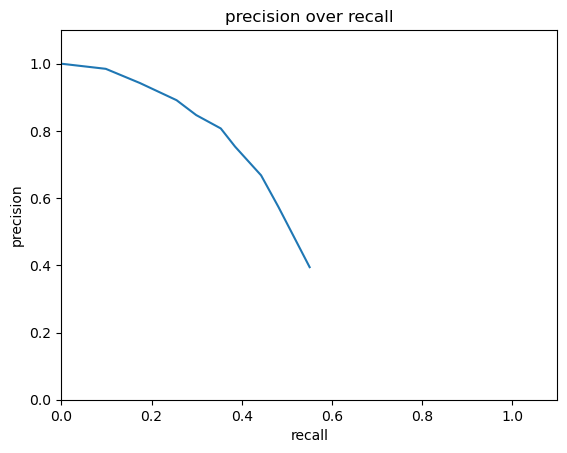

Epoch 26/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.79it/s]


average train losses 0.5524201889832815
average test losses 1.692977567810958
average precision 0.4700565895010339
test_precision 0.7783974146785398
test_recall 0.3623774373774374
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.02it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.26it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.07it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.89it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.59it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.93it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.61it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.82it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.03it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.47it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.74it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.17it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.43it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.39it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.13it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.96it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.94it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 179.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 197.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 197.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 197.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 197.06it/s]

Max accuracy: 0.5374647405154134
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,47.980000,48.619999,53.750000,53.540001,50.689999,50.220001
1,42.169998,48.619999,49.400002,53.480000,48.980000,48.570000
2,42.169998,42.240002,42.470001,42.160000,45.639999,45.330002
3,34.570000,34.730000,34.990002,34.660000,33.590000,33.459999
4,17.850000,18.049999,26.799999,26.709999,26.410000,26.350000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.96it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.43it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.51it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.43it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.63it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.61it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.60it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.19it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.66it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.14it/s]

Max accuracy: 0.5537420517344362
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,48.619999,49.389999,53.750000,55.369999,53.540001
1,48.619999,49.299999,53.750000,55.290001,53.480000
2,48.619999,49.299999,49.400002,55.290001,53.480000
3,42.240002,49.299999,49.400002,49.439999,48.349998
4,42.240002,42.270000,42.470001,42.689999,42.160000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.89it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.45it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.78it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.59it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.98it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 100.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.21it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.18it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.43it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.60it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.39it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.64it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.89it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.24it/s]

Max accuracy: 0.5653114622852825
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.5500)


,0,1,2,3,4
0,53.750000,53.820000,55.369999,54.709999,53.540001
1,53.750000,53.820000,55.290001,56.529999,55.110001
2,53.750000,53.820000,55.290001,54.639999,53.480000
3,49.400002,54.959999,55.290001,54.639999,53.480000
4,49.400002,49.680000,55.290001,54.639999,53.480000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.60it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.55it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.43it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.13it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.96it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.07it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.80it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.94it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.10it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.49it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.26it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.21it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.77it/s]

Max accuracy: 0.5677903432273821
With filter threshold: tensor(0.0750)
With NMS threshold: tensor(0.5750)


,0,1,2,3,4
0,55.369999,55.000000,54.709999,54.200001,53.540001
1,56.040001,55.639999,55.320000,54.779999,54.090000
2,55.290001,54.919998,56.529999,55.910000,55.110001
3,55.290001,54.919998,54.639999,56.779999,55.919998
4,55.290001,54.919998,54.639999,54.130001,53.480000


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.37it/s]


average train losses 4.171333207024468
average test losses 3.533644212956442
average precision 0.3968007675078382
test_precision 0.8036856861119672
test_recall 0.22467275522831082
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 78.34it/s]


average train losses 2.294338411755032
average test losses 2.871925537912255
average precision 0.4918489915775934
test_precision 0.7814380991645336
test_recall 0.2984443539999096
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.51it/s]


average train losses 1.8338006337483723
average test losses 2.6646872604334795
average precision 0.4383789189809981
test_precision 0.7829624208034228
test_recall 0.2856833495722385
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.29it/s]


average train losses 1.6282451417711046
average test losses 2.282088475094901
average precision 0.5074827006474238
test_precision 0.7994485869440456
test_recall 0.31059691337469114
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.70it/s]


average train losses 1.5038312276204426
average test losses 2.2795326244457494
average precision 0.46005379696133386
test_precision 0.777877687801888
test_recall 0.30497033830367165
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.90it/s]


average train losses 0.9560517403814528
average test losses 1.80416577290266
average precision 0.4682087399407661
test_precision 0.7935445760530576
test_recall 0.3130335713669047
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.09it/s]


average train losses 0.8497045636177063
average test losses 1.7859646398202647
average precision 0.47588196502337915
test_precision 0.7854201453443457
test_recall 0.32694558527891865
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.04it/s]


average train losses 0.8077871203422546
average test losses 1.7879855679056245
average precision 0.5016128254295688
test_precision 0.772550072300886
test_recall 0.33366612811057256
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.62it/s]


average train losses 0.7641711499955919
average test losses 1.7879735216540829
average precision 0.4691612072502424
test_precision 0.7740179631801437
test_recall 0.3165251415251415
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.67it/s]


average train losses 0.7278924054569669
average test losses 1.5843430529335285
average precision 0.48080092588639595
test_precision 0.785720062795112
test_recall 0.34173419173419173
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.47it/s]


average train losses 0.7162379026412964
average test losses 1.7650621376316091
average precision 0.4745285104259464
test_precision 0.7876718559407144
test_recall 0.324858680414236
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 80.61it/s]


average train losses 0.711964746316274
average test losses 1.7554545653002214
average precision 0.5186396859704597
test_precision 0.7790949050323336
test_recall 0.35548083603639163
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.70it/s]


average train losses 0.6944673789872063
average test losses 1.6717593367835055
average precision 0.473761708377093
test_precision 0.7756874498264972
test_recall 0.3515543098876432
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.82it/s]


average train losses 0.6821163164244758
average test losses 1.861121314076277
average precision 0.4584966449267353
test_precision 0.7689700603609879
test_recall 0.33205662650107093
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.89it/s]


average train losses 0.6730952991379632
average test losses 1.7545219731127095
average precision 0.5193992361077552
test_precision 0.7787908911609208
test_recall 0.3625727153504932
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.16it/s]


average train losses 0.6602503259976705
average test losses 1.6444269223006023
average precision 0.46386871675333213
test_precision 0.7624387357337447
test_recall 0.33366499755388646
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.18it/s]


average train losses 0.6812304721938239
average test losses 1.8113890669794164
average precision 0.4835951366254397
test_precision 0.770852181040754
test_recall 0.36990550601661704
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.79it/s]


average train losses 0.654344916343689
average test losses 1.7616388576895932
average precision 0.4339542758228722
test_precision 0.7604665609824
test_recall 0.3282401754623977
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.12it/s]


average train losses 0.6715317832099067
average test losses 1.8867921298130965
average precision 0.47513494735716955
test_precision 0.7773429700302145
test_recall 0.34266433155322046
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.90it/s]


average train losses 0.6523211929533217
average test losses 1.706957641235444
average precision 0.4722641649409326
test_precision 0.7738620079286809
test_recall 0.348817129372685
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 101.09it/s]


average train losses 0.6479729413986206
average test losses 1.5978148351410175
average precision 0.5237884715934444
test_precision 0.7969075508508298
test_recall 0.3638716222049555
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.30it/s]


average train losses 0.641192270649804
average test losses 1.6344185609296176
average precision 0.47674897909940644
test_precision 0.7788615625961584
test_recall 0.35399620955176514
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.96it/s]


average train losses 0.6308794948789809
average test losses 1.7560979691878003
average precision 0.5269293869040385
test_precision 0.7853328197051995
test_recall 0.3660604827271494
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.40it/s]


average train losses 0.6197240220175849
average test losses 1.6896192281801476
average precision 0.4733478477262471
test_precision 0.7795209495675697
test_recall 0.352283416172305
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.29it/s]

average train losses 0.6116521159807841
average test losses 1.685726307374969
average precision 0.4729575232100485
test_precision 0.7867607108772947
test_recall 0.33665768387990613


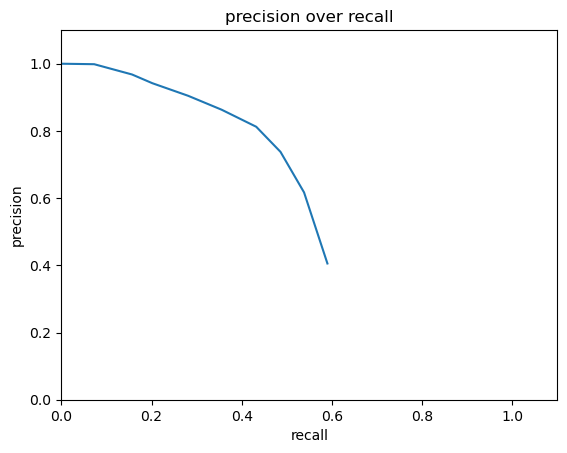

Epoch 26/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.89it/s]


average train losses 0.6157542334662544
average test losses 1.768145288539748
average precision 0.46976976734163994
test_precision 0.7733439487306324
test_recall 0.35102654547098994
Epoch 27/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.95it/s]


average train losses 0.6209605667326186
average test losses 1.6240976955688577
average precision 0.5286628728381033
test_precision 0.7782053078533601
test_recall 0.37810204199093084
Epoch 28/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.36it/s]


average train losses 0.6129215558369955
average test losses 1.5825793355958075
average precision 0.5160748156186803
test_precision 0.7856838621220186
test_recall 0.35906500906500904
Epoch 29/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.89it/s]


average train losses 0.5990310509999593
average test losses 1.7925370344494143
average precision 0.44575991666025383
test_precision 0.7584580700528392
test_recall 0.3381413853636076
Epoch 30/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.77it/s]


average train losses 0.604681220319536
average test losses 1.8359238268048674
average precision 0.4642557685486979
test_precision 0.7682177598903563
test_recall 0.33139340083784535
Epoch 31/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.11it/s]


average train losses 0.5935710867245992
average test losses 1.699546214203719
average precision 0.46659976042260426
test_precision 0.7720260426849731
test_recall 0.34701666646111096
Epoch 32/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.86it/s]


average train losses 0.599203368028005
average test losses 1.6480130018119798
average precision 0.5008916062015524
test_precision 0.765087658865037
test_recall 0.35404009570676237
Epoch 33/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.44it/s]


average train losses 0.6108489765061272
average test losses 1.7302939466007075
average precision 0.5126768054637642
test_precision 0.7791200278252582
test_recall 0.36483064260842035
Epoch 34/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.58it/s]


average train losses 0.5974461767408583
average test losses 1.722911820027903
average precision 0.4677040591570506
test_precision 0.7718436550528242
test_recall 0.3520633687300354
Epoch 35/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.92it/s]


average train losses 0.5925713777542114
average test losses 1.8014258494404307
average precision 0.4691881164103387
test_precision 0.7698468234916307
test_recall 0.34141763586208035
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.81it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.60it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.74it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.77it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.82it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.08it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.39it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.61it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.08it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.05it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.92it/s]

Max accuracy: 0.5468330444266436
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4,5
0,48.540001,50.040001,54.340000,54.680000,50.830002,50.209999
1,42.680000,50.040001,49.950001,54.619999,49.209999,48.639999
2,42.680000,42.980000,42.950001,49.419998,46.029999,45.580002
3,35.060001,35.029999,35.020000,34.770000,34.259998,34.080002
4,26.830000,26.830000,26.830000,26.770000,26.400000,26.320000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.14it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.14it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.05it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.33it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.45it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.96it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.59it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.19it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.59it/s]

Max accuracy: 0.555794334301154
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,54.340000,55.580002,54.680000,53.990002,50.830002
1,54.340000,55.500000,54.619999,53.930000,50.799999
2,49.950001,55.500000,54.619999,51.860001,49.209999
3,49.950001,49.610001,49.419998,47.900002,46.029999
4,42.950001,42.799999,49.419998,47.900002,46.029999


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.96it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.55it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.99it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.50it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.51it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.25it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.30it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.74it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.70it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.54it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.70it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.09it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.05it/s]

Max accuracy: 0.5681152849555708
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.5500)


,0,1,2,3,4
0,54.340000,54.110001,55.580002,54.980000,54.680000
1,54.340000,54.110001,55.500000,56.810001,56.220001
2,54.340000,54.110001,55.500000,54.910000,54.619999
3,55.369999,55.169998,55.500000,54.910000,54.619999
4,49.950001,49.880001,55.500000,54.910000,54.619999


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.70it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.51it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.20it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.59it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.42it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.82it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.31it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.78it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.02it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.15it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.35it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.07it/s]

Max accuracy: 0.5773210214003895
With filter threshold: tensor(0.0750)
With NMS threshold: tensor(0.5750)


,0,1,2,3,4
0,55.580002,55.250000,54.980000,55.150002,54.680000
1,56.270000,55.919998,55.619999,55.759998,55.250000
2,55.500000,57.200001,56.810001,56.860001,56.220001
3,55.500000,55.169998,54.910000,57.730000,57.029999
4,55.500000,55.169998,54.910000,55.080002,54.619999


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 83.86it/s]


average train losses 4.967625670962864
average test losses 3.7822959059663646
average precision 0.4054727304594342
test_precision 0.7829608276622909
test_recall 0.23989816767594546
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.46it/s]


average train losses 2.517385972870721
average test losses 2.721282028404736
average precision 0.46129864911916196
test_precision 0.7776778671283977
test_recall 0.29864960142737923
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.69it/s]


average train losses 1.8878559271494548
average test losses 2.5154479252986417
average precision 0.4666637701991237
test_precision 0.7848912780831396
test_recall 0.29938209938209936
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.47it/s]


average train losses 1.6668865150875516
average test losses 2.5658215272460567
average precision 0.46837035733351834
test_precision 0.7939211499349031
test_recall 0.3038063788063788
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.50it/s]


average train losses 1.504346251487732
average test losses 2.3134060607336866
average precision 0.456966758744148
test_precision 0.7685919630105488
test_recall 0.30479726035281596
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.21it/s]


average train losses 0.9335599939028422
average test losses 1.734488600806633
average precision 0.46277465777118176
test_precision 0.7836751474175465
test_recall 0.3105971189304523
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.50it/s]


average train losses 0.8066356182098389
average test losses 1.7645098921707554
average precision 0.42458568615717157
test_precision 0.7636585470201005
test_recall 0.2883416994528105
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.98it/s]


average train losses 0.756583591302236
average test losses 1.7838921951092885
average precision 0.5195100192010148
test_precision 0.8017232958239668
test_recall 0.337891018446574
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.57it/s]


average train losses 0.7332586579852634
average test losses 1.7478127693943148
average precision 0.47190404813753695
test_precision 0.7748517860033121
test_recall 0.32891069835514286
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.14it/s]


average train losses 0.7232428590456644
average test losses 1.6975115505166543
average precision 0.5242337222620828
test_precision 0.7877552107738588
test_recall 0.353337711671045
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.85it/s]


average train losses 0.7003325687514411
average test losses 1.7125158932728646
average precision 0.4380303506727785
test_precision 0.7684567686787787
test_recall 0.315554712776935
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.95it/s]


average train losses 0.6826874812444051
average test losses 1.6559351843561543
average precision 0.4769178726249434
test_precision 0.79211491398063
test_recall 0.33572230238896905
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.24it/s]


average train losses 0.6892823643154569
average test losses 1.6801996175889615
average precision 0.4839650529044468
test_precision 0.7928312378992924
test_recall 0.3494294799850356
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.67it/s]


average train losses 0.6717007954915365
average test losses 1.6995442814254693
average precision 0.47764471995241226
test_precision 0.7811117044980826
test_recall 0.35297480297480294
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.93it/s]


average train losses 0.6718902786572775
average test losses 1.6978306220127986
average precision 0.4724641613530503
test_precision 0.7848830166943427
test_recall 0.3235318179762624
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.72it/s]


average train losses 0.675489154126909
average test losses 1.8680746043127487
average precision 0.4650108158678321
test_precision 0.766885717230482
test_recall 0.323012173012173
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.78it/s]


average train losses 0.6564088397555881
average test losses 1.714414980209451
average precision 0.43865010680065253
test_precision 0.7681370631599882
test_recall 0.308370641703975
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.36it/s]


average train losses 0.650023341178894
average test losses 1.7514864872408729
average precision 0.4694460375015931
test_precision 0.7741946323799928
test_recall 0.34494065605176716
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.38it/s]


average train losses 0.6554371383455064
average test losses 1.7633363791977579
average precision 0.4745092872929948
test_precision 0.7854171392911933
test_recall 0.34233133122022014
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.00it/s]


average train losses 0.6330678860346476
average test losses 1.840942354835676
average precision 0.46925112146404013
test_precision 0.7834760879364586
test_recall 0.33463933186155403
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.17it/s]


average train losses 0.634892053074307
average test losses 1.7064589312316005
average precision 0.4607845371003265
test_precision 0.7771720193532385
test_recall 0.3315159120714677
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.82it/s]


average train losses 0.6178934574127197
average test losses 1.7591496741245276
average precision 0.47704104724306745
test_precision 0.7811628414161844
test_recall 0.3536052424941314
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.93it/s]


average train losses 0.6165884865654839
average test losses 1.6302888847441754
average precision 0.4986254766557797
test_precision 0.7980621170991606
test_recall 0.37059709837487614
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.78it/s]


average train losses 0.6294872429635789
average test losses 1.8519184293697701
average precision 0.4529360514014749
test_precision 0.7510493677248548
test_recall 0.33292335236779685
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.72it/s]


average train losses 0.6279027528232999
average test losses 1.6794866015259018
average precision 0.4726144714878204
test_precision 0.7834124642129073
test_recall 0.34224993113882
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.68it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.13it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.07it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.31it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.20it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.31it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.31it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.03it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.97it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.64it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.45it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.36it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.24it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.80it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.64it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.85it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.82it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.67it/s]

Max accuracy: 0.5419329717251496
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,48.410000,48.880001,54.189999,53.930000,50.389999,49.790001
1,42.520000,48.880001,49.770000,53.869999,48.720001,48.189999
2,42.520000,42.419998,42.759998,42.220001,45.380001,44.970001
3,34.910000,34.880001,34.889999,34.660000,33.450001,33.279999
4,26.730000,26.730000,26.740000,26.690001,26.330000,26.260000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.26it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.68it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.51it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.91it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.25it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.83it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.08it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.58it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.49it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.71it/s]


Max accuracy: 0.5419329717251496
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4
0,48.880001,49.599998,54.189999,53.580002,53.930000
1,48.880001,49.509998,54.189999,53.500000,53.869999
2,48.880001,49.509998,49.770000,49.439999,53.869999
3,42.419998,49.509998,49.770000,49.439999,48.560001
4,42.419998,42.439999,42.759998,42.619999,42.220001


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.82it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.67it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.79it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.62it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.23it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.35it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.57it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.45it/s]

Max accuracy: 0.5505257173222475
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.4500)


,0,1,2,3,4
0,49.599998,49.930000,54.189999,53.939999,53.580002
1,49.509998,52.470001,54.189999,53.939999,53.500000
2,49.509998,49.840000,54.189999,53.939999,53.500000
3,49.509998,49.840000,49.770000,55.049999,54.669998
4,49.509998,49.840000,49.770000,49.639999,49.439999


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.78it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.45it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.95it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.52it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.64it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.93it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.05it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.46it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.94it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.08it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.48it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.39it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.84it/s]

Max accuracy: 0.5509500669676274
With filter threshold: tensor(0.1750)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,54.189999,54.119999,53.939999,53.759998,53.500000
1,54.880001,54.810001,54.630001,54.459999,54.189999
2,49.770000,49.730000,55.049999,54.910000,54.669998
3,49.770000,49.730000,49.639999,49.570000,55.099998
4,49.770000,49.730000,49.639999,49.570000,49.439999


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.79it/s]


average train losses 4.473281330532497
average test losses 3.5469272561222738
average precision 0.4159826671109576
test_precision 0.7877107952704067
test_recall 0.24487611154277822
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.81it/s]


average train losses 2.340408590104845
average test losses 2.8692807725012472
average precision 0.4614619128605142
test_precision 0.7725054635592998
test_recall 0.3055831000275444
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.94it/s]


average train losses 1.8892877101898193
average test losses 2.502330332230299
average precision 0.4542974460527477
test_precision 0.7687918308172831
test_recall 0.291539838762061
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.70it/s]


average train losses 1.6536180310779147
average test losses 2.375182532686793
average precision 0.4615448826404538
test_precision 0.773496241325261
test_recall 0.31713882824993933
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.24it/s]


average train losses 1.5316508478588529
average test losses 2.3611089125318063
average precision 0.43697639530160987
test_precision 0.7728939175357996
test_recall 0.30213428546761883
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.07it/s]


average train losses 0.923409018251631
average test losses 1.757958931227525
average precision 0.4449803371055728
test_precision 0.7886363933117012
test_recall 0.29653535764646877
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.17it/s]


average train losses 0.7992004884613885
average test losses 1.788914095111552
average precision 0.47023788321379617
test_precision 0.7833698380172488
test_recall 0.3230201896868563
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.57it/s]


average train losses 0.7634216414557563
average test losses 1.6578203898209791
average precision 0.477950503256733
test_precision 0.790730981220924
test_recall 0.31712628934851156
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 102.89it/s]


average train losses 0.750122951136695
average test losses 1.7119652638875182
average precision 0.4706702977876249
test_precision 0.7774078508728935
test_recall 0.31768437323992876
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.90it/s]


average train losses 0.7193004952536689
average test losses 1.7355800697266885
average precision 0.4391252856197228
test_precision 0.7688098654957782
test_recall 0.31675125286236394
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.37it/s]


average train losses 0.7044125265545316
average test losses 1.7933025662800526
average precision 0.4629618100834792
test_precision 0.7784757314569006
test_recall 0.32090039590039593
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.14it/s]


average train losses 0.6959323883056641
average test losses 1.7425440737494715
average precision 0.4741038135366029
test_precision 0.7864408979269013
test_recall 0.3390601168378946
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.91it/s]


average train losses 0.6801879604657491
average test losses 1.7235136104487625
average precision 0.5251161167429518
test_precision 0.7841927663197853
test_recall 0.36077626077626074
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.35it/s]


average train losses 0.6769101818402609
average test losses 1.7459247814241978
average precision 0.5328069651837116
test_precision 0.8007414082882188
test_recall 0.3655138071804738
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.98it/s]


average train losses 0.6613713569111295
average test losses 1.682973586553522
average precision 0.4708075968176978
test_precision 0.7846949259616296
test_recall 0.3270494937161604
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.88it/s]


average train losses 0.6661601265271505
average test losses 1.7167968412707335
average precision 0.4488529919969124
test_precision 0.7748802629940555
test_recall 0.32982922427366873
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.40it/s]


average train losses 0.6581834885809157
average test losses 1.6356463463090762
average precision 0.46948006759072897
test_precision 0.7799181908169899
test_recall 0.32942006553117664
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.75it/s]


average train losses 0.6406658755408393
average test losses 1.8270102129065753
average precision 0.47419175474731023
test_precision 0.7797302145912687
test_recall 0.3381452909230688
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.81it/s]


average train losses 0.6432428823577033
average test losses 1.7193312316368787
average precision 0.5276048383638023
test_precision 0.7839712055290058
test_recall 0.3821173682284793
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.97it/s]


average train losses 0.6440695855352614
average test losses 1.9435726463624894
average precision 0.45883965454672526
test_precision 0.7747481495082482
test_recall 0.32641381252492363
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.50it/s]


average train losses 0.638163513607449
average test losses 1.6964099020020575
average precision 0.47892856301947206
test_precision 0.7873780122829319
test_recall 0.3436032074920964
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.59it/s]


average train losses 0.6383003128899468
average test losses 1.7538855818559302
average precision 0.4640923588636007
test_precision 0.7616322360545773
test_recall 0.33538313538313536
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.62it/s]


average train losses 0.6409465803040398
average test losses 1.7926547564672268
average precision 0.4683727564846446
test_precision 0.7702096368486995
test_recall 0.3302297496741941
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.18it/s]


average train losses 0.6318003469043307
average test losses 1.833652677847619
average precision 0.47551318505086954
test_precision 0.7793214791786481
test_recall 0.36071531349309127
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.91it/s]


average train losses 0.7408862577544318
average test losses 1.9487940000842439
average precision 0.4687935470958004
test_precision 0.7721556880795444
test_recall 0.3423192034303145
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.66it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.98it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.19it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.85it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.07it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.51it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.61it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.91it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.48it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.56it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.30it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.75it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.75it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.95it/s]

Max accuracy: 0.543496449696505
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,48.400002,49.790001,54.349998,54.349998,51.439999,50.790001
1,42.529999,49.790001,49.770000,54.279999,49.619999,49.049999
2,42.529999,42.680000,42.680000,42.570000,46.180000,45.730000
3,34.849998,34.810001,34.820000,34.990002,34.060001,33.900002
4,26.680000,26.670000,26.670000,26.620001,26.219999,26.139999
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.69it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.53it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.31it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.78it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.77it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.37it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.22it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.24it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.47it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.90it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.58it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.16it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.99it/s]

Max accuracy: 0.543496449696505
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4
0,49.790001,49.900002,54.349998,53.680000,54.349998
1,49.790001,49.810001,54.349998,53.590000,54.279999
2,49.790001,49.810001,49.770000,49.439999,54.279999
3,49.790001,49.810001,49.770000,49.439999,48.970001
4,42.680000,42.689999,42.680000,42.540001,42.570000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.48it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.80it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.00it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.16it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.06it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.71it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.07it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.56it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.19it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 90.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.48it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.27it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.50it/s]

Max accuracy: 0.5513098407436691
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.4500)


,0,1,2,3,4
0,49.900002,54.529999,54.349998,53.990002,53.680000
1,52.730000,54.529999,54.349998,53.990002,53.590000
2,49.810001,54.529999,54.349998,53.990002,53.590000
3,49.810001,49.810001,49.770000,55.130001,54.770000
4,49.810001,49.810001,49.770000,49.619999,49.439999


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.14it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.16it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.74it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.37it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.92it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.82it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.48it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.58it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.06it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.80it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.55it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.89it/s]

Max accuracy: 0.552812912397646
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.4250)


,0,1,2,3,4
0,54.349998,54.180000,53.990002,53.820000,53.590000
1,54.889999,54.720001,54.540001,54.369999,54.160000
2,49.770000,55.279999,55.130001,54.959999,54.770000
3,49.770000,49.689999,49.619999,49.540001,55.099998
4,49.770000,49.689999,49.619999,49.540001,49.439999


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.89it/s]


average train losses 4.145736085044013
average test losses 3.213562260326157
average precision 0.42072103192027727
test_precision 0.8005038903848987
test_recall 0.2561635894969228
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.00it/s]


average train losses 2.313432428571913
average test losses 2.7461476319196216
average precision 0.42685517928336575
test_precision 0.7711774967409405
test_recall 0.2749139749139749
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.62it/s]


average train losses 1.842794073952569
average test losses 2.602192825061983
average precision 0.4428175970065453
test_precision 0.7566325493138379
test_recall 0.29675879675879674
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.64it/s]


average train losses 1.641676664352417
average test losses 2.3768725843511076
average precision 0.4671108292468959
test_precision 0.7864356117480087
test_recall 0.30017215294993077
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.30it/s]


average train losses 1.4883526961008708
average test losses 2.368896277881416
average precision 0.4541098653569515
test_precision 0.761585548352848
test_recall 0.3118853368853369
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.66it/s]


average train losses 0.9250254299905565
average test losses 1.7112988019176358
average precision 0.47292736832363863
test_precision 0.7949322814118456
test_recall 0.3113057724168835
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.58it/s]


average train losses 0.8060339225663079
average test losses 1.7255102750285398
average precision 0.48038849693861346
test_precision 0.796711727053563
test_recall 0.33348349181682513
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.37it/s]


average train losses 0.7535865373081632
average test losses 1.7263307267019892
average precision 0.4519454206482864
test_precision 0.7625342530106525
test_recall 0.3120010647788426
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.53it/s]


average train losses 0.729544202486674
average test losses 1.623969556747848
average precision 0.47254347317478623
test_precision 0.7805157132303026
test_recall 0.32262521429188096
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.90it/s]


average train losses 0.6991037461492751
average test losses 1.7382986413107977
average precision 0.4704785808081206
test_precision 0.7790755568292121
test_recall 0.33229137118026003
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.18it/s]


average train losses 0.7026215460565355
average test losses 1.7203498578648961
average precision 0.4780319474763919
test_precision 0.7857648616748305
test_recall 0.34395326895326894
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.11it/s]


average train losses 0.6853091319402059
average test losses 1.7230934991456166
average precision 0.4807573692674703
test_precision 0.7880920133305155
test_recall 0.3501371056926612
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.64it/s]


average train losses 0.688568221198188
average test losses 1.703714377689905
average precision 0.5362987323944955
test_precision 0.7951256463189552
test_recall 0.3694853500409056
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.76it/s]


average train losses 0.679601768652598
average test losses 1.6646513903879712
average precision 0.46289610199866615
test_precision 0.7660712123025615
test_recall 0.3338790838790838
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 97.36it/s]


average train losses 0.6629197597503662
average test losses 1.6419591194926164
average precision 0.5042643851755649
test_precision 0.7701433611906624
test_recall 0.35262741373852485
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.38it/s]


average train losses 0.663035061624315
average test losses 1.8051380327029785
average precision 0.5135288865476849
test_precision 0.7708425606704357
test_recall 0.35528524972969416
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.93it/s]


average train losses 0.6527807580100166
average test losses 1.71934192610687
average precision 0.5284491498194777
test_precision 0.7880636798995387
test_recall 0.36928020539131645
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.72it/s]


average train losses 0.6532146599557664
average test losses 1.8437859527236036
average precision 0.4383311382540095
test_precision 0.7700218687992352
test_recall 0.3145226173003951
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.45it/s]


average train losses 0.6547846462991502
average test losses 1.7212715228101467
average precision 0.45259832766776226
test_precision 0.7750876069715584
test_recall 0.32889815945371503
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.98it/s]


average train losses 0.6594618029064603
average test losses 1.821169763538148
average precision 0.46402099799535695
test_precision 0.7606538275169203
test_recall 0.3389658695214251
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.50it/s]


average train losses 0.6583211620648702
average test losses 1.6069911259871263
average precision 0.47193549996580303
test_precision 0.7800169556391576
test_recall 0.3567565150898484
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.51it/s]


average train losses 0.6516355872154236
average test losses 1.7528919955222015
average precision 0.4652471632658113
test_precision 0.7733371143079083
test_recall 0.3260213037990816
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 90.52it/s]


average train losses 0.635360492600335
average test losses 1.7642823220827641
average precision 0.5114360026871339
test_precision 0.7860310886999491
test_recall 0.3509509009509009
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.00it/s]


average train losses 0.630771173371209
average test losses 1.7142752162114507
average precision 0.45121124666579215
test_precision 0.7492136923883096
test_recall 0.348662140328807
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.77it/s]


average train losses 0.6155250403616164
average test losses 1.719037329199647
average precision 0.46015458181347846
test_precision 0.7628972804452294
test_recall 0.3340713812936035
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 35.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.54it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.54it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.94it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.10it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.14it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.58it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.13it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.47it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.54it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.03it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.93it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.75it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.09it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.38it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.60it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.42it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.82it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.30it/s]

Max accuracy: 0.5447303619651063
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4,5
0,48.639999,49.689999,54.470001,54.150002,51.209999,50.570000
1,42.689999,49.689999,49.959999,54.080002,49.410000,48.849998
2,42.689999,42.560001,42.919998,42.410000,45.939999,45.490002
3,34.980000,34.950001,34.950001,34.720001,33.619999,33.439999
4,26.740000,26.740000,26.740000,26.680000,26.340000,26.270000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.68it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.16it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.71it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.41it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.24it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.62it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.12it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.07it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.80it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.74it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.33it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.20it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.81it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.26it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.46it/s]

Max accuracy: 0.5447303619651063
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.4000)


,0,1,2,3,4
0,49.689999,50.150002,54.470001,53.770000,54.150002
1,49.689999,50.060001,54.470001,53.689999,54.080002
2,49.689999,50.060001,49.959999,49.619999,54.080002
3,49.689999,50.060001,49.959999,49.619999,48.759998
4,42.560001,42.939999,42.919998,42.779999,42.410000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.54it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.55it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.11it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.46it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.43it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.83it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.49it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.16it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.17it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.69it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 111.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.04it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.17it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.77it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.14it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 111.02it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.45it/s]

Max accuracy: 0.5521093781890332
With filter threshold: tensor(0.1500)
With NMS threshold: tensor(0.4500)


,0,1,2,3,4
0,50.150002,54.709999,54.470001,54.150002,53.770000
1,52.880001,54.709999,54.470001,54.150002,53.689999
2,50.060001,54.709999,54.470001,54.150002,53.689999
3,50.060001,50.040001,49.959999,55.209999,54.799999
4,50.060001,50.040001,49.959999,49.820000,49.619999


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.60it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.84it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.58it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.18it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.41it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.36it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.00it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.86it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.40it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.94it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.73it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.52it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.08it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.10it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.23it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.29it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.59it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.34it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.98it/s]

Max accuracy: 0.5553116400357395
With filter threshold: tensor(0.1750)
With NMS threshold: tensor(0.4750)


,0,1,2,3,4
0,54.470001,54.330002,54.150002,53.950001,53.689999
1,55.080002,54.930000,54.759998,54.580002,54.310001
2,49.959999,55.360001,55.209999,55.040001,54.799999
3,49.959999,49.889999,49.820000,55.529999,55.290001
4,49.959999,49.889999,49.820000,49.740002,49.619999


Epoch 1/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.27it/s]


average train losses 4.240169233745998
average test losses 3.6121691927271353
average precision 0.404220277125833
test_precision 0.7775075429767744
test_recall 0.2257183146072035
Epoch 2/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 86.72it/s]


average train losses 2.406149294641283
average test losses 2.9750807957771497
average precision 0.455110517194924
test_precision 0.769159984445497
test_recall 0.2785079118412451
Epoch 3/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.74it/s]


average train losses 1.9272314972347684
average test losses 2.7596843721520186
average precision 0.431387093287149
test_precision 0.7724192294361242
test_recall 0.2685043351710018
Epoch 4/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 96.25it/s]


average train losses 1.6848674482769437
average test losses 2.5343008895545265
average precision 0.438638589525465
test_precision 0.7850589408730958
test_recall 0.2771648104981438
Epoch 5/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.33it/s]


average train losses 1.5532151725557115
average test losses 2.3534216030880257
average precision 0.4625191774181673
test_precision 0.7786333166895434
test_recall 0.30292115292115285
Epoch 6/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.02it/s]


average train losses 0.9453111688296
average test losses 1.6956738828339128
average precision 0.5069239465071895
test_precision 0.7920316001454549
test_recall 0.3172134449912227
Epoch 7/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.38it/s]


average train losses 0.8186479674445258
average test losses 1.785825055676308
average precision 0.4581994054896152
test_precision 0.7715787405991322
test_recall 0.3184138906361129
Epoch 8/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.72it/s]


average train losses 0.812284959687127
average test losses 1.7663142862185794
average precision 0.4643602985663746
test_precision 0.7745501414987549
test_recall 0.3162076606521051
Epoch 9/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.80it/s]


average train losses 0.8181130753623115
average test losses 1.8207634975682636
average precision 0.49908415230938774
test_precision 0.7816216214248507
test_recall 0.32018896741118963
Epoch 10/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 87.14it/s]


average train losses 0.9568968349032931
average test losses 1.7756920331648611
average precision 0.46386117623491363
test_precision 0.776551576050166
test_recall 0.3235298651965319
Epoch 11/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.45it/s]


average train losses 0.916633665561676
average test losses 1.8135238039782244
average precision 0.4674730479023408
test_precision 0.772044361528985
test_recall 0.33354310298754747
Epoch 12/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 99.51it/s]


average train losses 0.8384592533111572
average test losses 1.7080747868515487
average precision 0.5086370863020101
test_precision 0.7786710838878095
test_recall 0.3463258963258963
Epoch 13/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.48it/s]


average train losses 0.7414606610933939
average test losses 1.8408154192515926
average precision 0.46615503161277655
test_precision 0.7703920655123873
test_recall 0.3330029024473469
Epoch 14/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 94.76it/s]


average train losses 0.6939719584253099
average test losses 1.6866862271246408
average precision 0.47381950656037686
test_precision 0.7824416144612331
test_recall 0.33184942629387076
Epoch 15/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.00it/s]


average train losses 0.684785332944658
average test losses 1.7106371713202564
average precision 0.5028282384850484
test_precision 0.7750179796649329
test_recall 0.34380742714076046
Epoch 16/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 84.24it/s]


average train losses 0.6830704278416104
average test losses 1.7761897235854058
average precision 0.5097333111058716
test_precision 0.785071150743592
test_recall 0.3502097696542141
Epoch 17/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 95.59it/s]


average train losses 0.6727410157521566
average test losses 1.5694730554274854
average precision 0.5107108140076969
test_precision 0.7727457786985187
test_recall 0.358352141685475
Epoch 18/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 98.04it/s]


average train losses 0.6555811299218072
average test losses 1.58872170217781
average precision 0.472976097976098
test_precision 0.7781644189640718
test_recall 0.35061224783447004
Epoch 19/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 87.62it/s]


average train losses 0.6503965192370944
average test losses 1.720681162726166
average precision 0.5097222903743996
test_precision 0.7795726382590499
test_recall 0.3603124242013131
Epoch 20/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 85.70it/s]


average train losses 0.6449442505836487
average test losses 1.7804314372291592
average precision 0.4586089110176134
test_precision 0.7648921193455559
test_recall 0.3383142577587022
Epoch 21/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.49it/s]


average train losses 0.646593279308743
average test losses 1.6889045966147018
average precision 0.46431342326595165
test_precision 0.7636790687437217
test_recall 0.338717455384122
Epoch 22/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 89.39it/s]


average train losses 0.6462324791484408
average test losses 1.831419636529905
average precision 0.44722434861773974
test_precision 0.7697442662956171
test_recall 0.3281027614360948
Epoch 23/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 91.55it/s]


average train losses 0.6333843138482835
average test losses 1.6171191098258706
average precision 0.4763792678465725
test_precision 0.7805108271043522
test_recall 0.3578564439675551
Epoch 24/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 92.25it/s]


average train losses 0.6287768019570245
average test losses 1.812477365263507
average precision 0.514667514515001
test_precision 0.7797053655748366
test_recall 0.35675826231381785
Epoch 25/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 93.90it/s]

average train losses 0.6154621640841166
average test losses 1.7657695236878517
average precision 0.5254315840341165
test_precision 0.7962922558886251
test_recall 0.36326225215114105


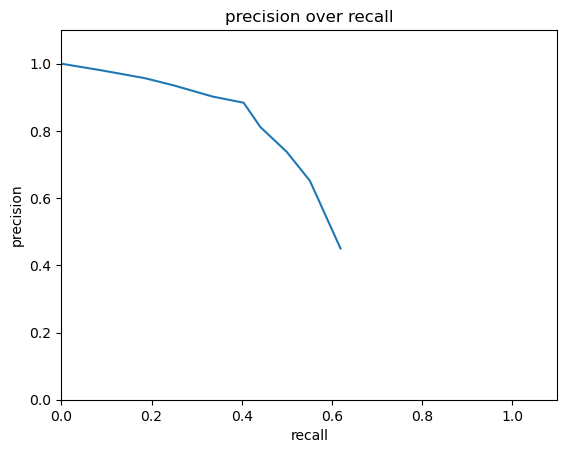

Epoch 26/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:03<00:00, 88.79it/s]


average train losses 0.637192878458235
average test losses 1.778419022206907
average precision 0.5193191730412651
test_precision 0.7920477131527975
test_recall 0.3588043643599199
Epoch 27/300
------------------------Training-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


------------------------Validation-----------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:04<00:00, 82.66it/s]


average train losses 0.6271297468079461
average test losses 1.8923870409995402
average precision 0.43717118821442597
test_precision 0.7666361398181866
test_recall 0.32392186003297113
------------------------EARLY STOPPING------------------------
------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.78it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.65it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.28it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.15it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.21it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.77it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.14it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.22it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.26it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.87it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.44it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.26it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.13it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.48it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.10it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.77it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.99it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.76it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.11it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.88it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.72it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.28it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.43it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.67it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.91it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.32it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.79it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.54it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.91it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.45it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.73it/s]

Max accuracy: 0.5457210229024922
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.6000)


,0,1,2,3,4,5
0,48.180000,49.560001,53.889999,54.570000,50.619999,50.009998
1,42.389999,49.560001,49.509998,54.500000,48.919998,48.380001
2,42.389999,42.570000,42.560001,49.320000,45.650002,45.230000
3,34.830002,34.779999,34.790001,34.939999,33.930000,33.759998
4,26.660000,26.660000,26.670000,26.610001,26.180000,26.100000
5,9.090000,9.090000,9.090000,9.090000,9.090000,9.090000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.60it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.41it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.20it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.07it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.91it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.63it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.60it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.03it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.65it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.01it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.25it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.58it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.50it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.07it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.13it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.84it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.44it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.54it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.08it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.35it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.85it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.86it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.81it/s]

Max accuracy: 0.5503617306471412
With filter threshold: tensor(0.)
With NMS threshold: tensor(0.5000)


,0,1,2,3,4
0,53.889999,55.040001,54.570000,53.660000,50.619999
1,53.889999,54.950001,54.500000,53.610001,50.590000
2,49.509998,54.950001,54.500000,51.459999,48.919998
3,49.509998,49.139999,49.320000,47.500000,45.650002
4,42.560001,42.410000,49.320000,47.500000,45.650002


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.36it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.56it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.90it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.24it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.68it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.36it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.57it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.76it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.04it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.40it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.02it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.09it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.71it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.80it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.38it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.29it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.97it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.40it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.95it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.68it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.80it/s]


------------------------Validation-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.53it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.76it/s]

Max accuracy: 0.5660559445167702
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.5500)


,0,1,2,3,4
0,53.889999,53.639999,55.040001,54.779999,54.570000
1,53.889999,53.639999,54.950001,56.610001,56.150002
2,53.889999,53.639999,54.950001,54.709999,54.500000
3,49.509998,54.720001,54.950001,54.709999,54.500000
4,49.509998,49.430000,54.950001,54.709999,54.500000


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.47it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.64it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.99it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.66it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.18it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.93it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.77it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.72it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.55it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.36it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.27it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.83it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.01it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.55it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.37it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.32it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.08it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.80it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.39it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.72it/s]


------------------------Validation-----------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.79it/s]

Max accuracy: 0.5704503638219516
With filter threshold: tensor(0.0500)
With NMS threshold: tensor(0.5250)


,0,1,2,3,4
0,55.040001,55.099998,54.779999,54.349998,54.570000
1,55.720001,55.770000,55.430000,54.950001,55.150002
2,54.950001,57.049999,56.610001,56.029999,56.150002
3,54.950001,55.020000,54.709999,56.950001,57.029999
4,54.950001,55.020000,54.709999,54.279999,54.500000


Max accuracy: tensor(0.5773)


IndexError: index 8 is out of bounds for dimension 0 with size 4

In [13]:
layers = [[], ['1', '2', '3'], ['1', '2', '3', '4', '5',], ['1', '2', '3', '4', '5', '6', '7']]
weight_decays = [0, 0.00001, 0.001, 0.1]


max_accs = torch.zeros(len(layers), len(weight_decays))
max_nms = torch.zeros_like(max_accs)
max_filter = torch.zeros_like(max_accs)

for i in range(len(layers)):
    for j in range(len(weight_decays)):
        sd = torch.load("results/voc_finetuned_123_frozen_layers_300_epochs_00003_lr_0001_decay.pt")
        sd = fuse(sd)
        sd = longtrain(MyTinyYoloV2, state_dict=sd, device=device, frozen_layers=layers[i], lr=0.00003, weight_decay=weight_decays[j], train_batch_size=256, epochs=300)
        max_accs[i], max_nms[i], max_filter[i] = identify_threshold(MyTinyYoloV2, sd, device=device)

index = torch.argmax(max_accs)
print('Max accuracy:', torch.max(max_accs))
print('With filter threshold:', max_filter[index])
print('With NMS threshold:', max_nms[index])
print('With anchor_count:', index + 1)



In [ ]:
torch.save(net.cpu().state_dict(), f"models/configs/voc_fused.pt")

In [ ]:
torch.save(sd, f"models/configs/voc_fused4.pt")